# Clustering of Temporal Profiles over Months Tracking Changing Clusters
###### This notebook looks at clustering users based on their temporal travel patterns for a selected time period (e.g. a week or a month) tracking clusters from two time periods to look at change. This is the full process of this code:
1. Imports and Constants: Constants are defined such as how hours are mapped into Morning, Day, etc...
2. Query data and create User profiles: Users are represented based on all their journeys (not trips) from selected time periods where this is mapped to the hour of the day and whether it is a weekday or a weekend. Each user is represented as one row with features such as Weekday_09, Weekend_02,  where all journeys have been aggregating. Users with fewer than four journeys are dropped, and afterwards these rows are normalized. 
3. Manual grouping: Group users manually based on ticket category (here simplified to Period, Tourist, School, and Single).
4. Sampling users: Users are sampled to cover all types of tickets this is done to reduce computational cost, but might be possible to just keep all. The sampling is done to mainly keep users that traveled in both periods examined.
5. Clustering per Ticket Category: Gaussian Mixture Model (GMM) is applied for each category of tickets where the parameter selection is done using within-cluster sum of squared (WCSS) selecting k from the elbow plot. Both algorithm and input paramter choice can be alterted easily.
6. Cluster refinement: Hierarchical agglomerative clustering (HAC) is applied over all clusters after GMM is applied to all ticket categories. This creates a set of final reduced profiles where the number of profiles to keep can be a bit trial and error looking at the dendogram, testing, and evaluating sizes and patterns found.
7. Cluster mapping: Clusters are randomly labeled by GMM and HAC here we use Jaccard similarity based on the CardKey to map clusters over time so that cluster 1 equals cluster 1 between P1 and P2. This builds on the assumptions that users rarely change or that they change together. 
8. Analysis and evaluation: Cluster sizes, membership movement, and temporal profiles can be compared for P1 and P2. 


## 1. Imports and Constants

### Imports

In [1]:
# Spark SQL Imports
from pyspark.sql.types import *
from pyspark.sql import functions as F

# Clustering Algorithms
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.decomposition import PCA # For 2D projection
from sklearn.manifold import TSNE # For 2D projection
from mpl_toolkits.mplot3d import Axes3D
import scipy.cluster.hierarchy as sch

# Cluster Analysis
from sklearn.metrics import silhouette_score, pairwise_distances, jaccard_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial.distance import pdist, cdist
from sklearn.preprocessing import MinMaxScaler

# Common Data Science Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import adjusted_rand_score

# Common Python Imports
import math
import random
import time
from datetime import datetime

StatementMeta(dslsmall, 492, 2, Finished, Available)

### Constants

In [2]:
# Time Periods
TIME_PERIODS_NAME = ["November 2022", "January 2023", "April 2023", "July 2023", "November 2023", "January 2024"]
TIME_PERIODS = [["2000-01-01 00:00:00", "2000-01-01 00:00:00"] for i in range(6)]

# First 28 days of months (same number of each weekday, simplify analysis)
# November 2022
start_date = "2022-11-01 00:00:00"
end_date = "2022-11-28 00:00:00"
TIME_PERIODS[0] = [start_date, end_date]

# January 2023
start_date = "2023-01-01 00:00:00"
end_date = "2023-01-28 00:00:00"
TIME_PERIODS[1] = [start_date, end_date]

# April 2023
start_date = "2023-04-01 00:00:00"
end_date = "2023-04-28 00:00:00"
TIME_PERIODS[2] = [start_date, end_date]

# July 2024
start_date = "2024-07-01 00:00:00"
end_date = "2024-07-28 00:00:00"
TIME_PERIODS[3] = [start_date, end_date]

# November 2023
start_date = "2023-11-01 00:00:00"
end_date = "2023-11-28 00:00:00"
TIME_PERIODS[4] = [start_date, end_date]

# January 2024
start_date = "2024-01-01 00:00:00"
end_date = "2024-01-28 00:00:00"
TIME_PERIODS[5] = [start_date, end_date]

StatementMeta(dslsmall, 492, 3, Finished, Available)

In [3]:
# Day mappings, for English names only
DAY_MAPPING = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday' }
DAYS_ORDER = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

PERIOD_SAMPLING_FRACTIONS = {'Period': 0.10, 'Tourist': 1.0, 'School': 0.35, 'Single': 0.10}
CATEGORY_NUMBER_MAPPING = {"Period": 0, "Tourist": 1, "School": 2, "Single": 3} # Keep order constant

# ...
ID_COL = "CardKey"

StatementMeta(dslsmall, 492, 4, Finished, Available)

In [4]:
# Manually map ticket types into one out of four ticket categories (may potentially be further refined)
TICKET_CATEGORIES = ["Period", "Tourist", "School", "Single"]
CATEGORY_MAPPING = {
    "30-dagarsbiljetter": "Period", "90-dagarsbiljetter": "Period", "Års-och företagsbiljetter": "Period", # Split period into reduced and Adult to track students and elderly?
    "5-dagarsbiljetter": "Tourist", "7-dagarsbiljetter": "Tourist", "72-timmarsbiljett inkl app": "Tourist", "24-timmarsbiljett inkl app": "Tourist", 
    "Reskassa": "Single", "Kontaktlöst": "Single", "Mobilbiljett": "Single", "Zon och Automatbiljetter": "Single", # Split period into reduced and Adult to track students and elderly?
    "Skol- termins och fritidsbiljett": "School"
}

TICKET_MAPPING = {
    'Skolbiljett vårtermin': 'Skol- termins och fritidsbiljett', 'Skolbiljett hösttermin': 'Skol- termins och fritidsbiljett', 'Skolbiljett vårtermin skola': 'Skol- termins och fritidsbiljett', 
    'Skolbiljett hösttermin skola': 'Skol- termins och fritidsbiljett', 'Skolbiljett 90 dagar': 'Skol- termins och fritidsbiljett', 'Skolbiljett 90 dagar skola': 'Skol- termins och fritidsbiljett', 
    'Skolbiljett 120 dagar': 'Skol- termins och fritidsbiljett', 'Skolbiljett 120 dagar skola': 'Skol- termins och fritidsbiljett', 'Fritidsbiljett Hösttermin': 'Skol- termins och fritidsbiljett', 
    'Fritidsbiljett 90 dagar': 'Skol- termins och fritidsbiljett', 'Fritidsbiljett vårtermin': 'Skol- termins och fritidsbiljett', 'Fritidsbiljett 120 dagar': 'Skol- termins och fritidsbiljett', 
    'Läsårsbiljett plus skola': 'Skol- termins och fritidsbiljett', 'Läsårsbiljett skola': 'Skol- termins och fritidsbiljett', 'Fritidsbiljett 90 dagar skola': 'Skol- termins och fritidsbiljett', 
    'Skolbiljett UL/SL vårtermin': 'Skol- termins och fritidsbiljett', 'Fritidsbiljett UL/SL vårtermin': 'Skol- termins och fritidsbiljett', 
    'Skolbiljett UL/SL vårtermin Skola': 'Skol- termins och fritidsbiljett', 'Skolbiljett UL/SL hösttermin': 'Skol- termins och fritidsbiljett', 
    'Skolbiljett UL/SL hösttermin Skola': 'Skol- termins och fritidsbiljett', 'Fritidsbiljett UL/SL hösttermin': 'Skol- termins och fritidsbiljett', 
    'Fritidsbiljett 120 dagar skola': 'Skol- termins och fritidsbiljett', 'Fritidsbiljett HT Skola': 'Skol- termins och fritidsbiljett', 
    'Fritidsbiljett VT Skola': 'Skol- termins och fritidsbiljett', 'USLUL125': 'Zon och Automatbiljetter', 'USLUL25': 'Zon och Automatbiljetter', 'Årsbiljett Resplus': 'Års-och företagsbiljetter', 
    'Reskassa': 'Reskassa', '7-dagar vuxen': '7-dagarsbiljetter', '7-dagar vuxen ftg': '7-dagarsbiljetter', '24-timmar vuxen': '24-timmarsbiljett inkl app', '72-timmar vuxen': '72-timmarsbiljett inkl app', 
    'Arlanda + SL vuxen endast 1 passage': 'Zon och Automatbiljetter', 'Enkelbiljett_vuxen': 'Zon och Automatbiljetter', 'Enkelbiljett vuxen': 'Kontaktlöst', '30-dagar rabatterad': '30-dagarsbiljetter', 
    '30-dagar rabatterad ftg': '30-dagarsbiljetter', '30-dagar Arlanda rabatterad': '30-dagarsbiljetter', '90-dagar rabatterad': '90-dagarsbiljetter', '90-dagar rabatterad ftg': '90-dagarsbiljetter', 
    'Årsbiljett Jan-Dec rabatterad': 'Års-och företagsbiljetter', 'Årsbiljett rabatterad ftg': 'Års-och företagsbiljetter', 'Årsbiljett rabatterad': 'Års-och företagsbiljetter', 
    '7-dagar rabatterad': '7-dagarsbiljetter', '7-dagar rabatterad ftg': '7-dagarsbiljetter', '24-timmar rabatterad': '24-timmarsbiljett inkl app', '72-timmar rabatterad': '72-timmarsbiljett inkl app', 
    'Arlanda + SL rabatterad endast 1 passage': 'Zon och Automatbiljetter', 'WAX 30 dagar rabatterad': '30-dagarsbiljetter', 'Årsbiljett Jan-Dec FTG- rabatterad': 'Års-och företagsbiljetter', 
    'WAX 30-dagarsbiljett rabatterad FTG': '30-dagarsbiljetter', 'Årsbiljett Ftg rabatterad': 'Års-och företagsbiljetter', 'Enkelbiljett_rabatterad': 'Zon och Automatbiljetter', 
    'Enkelbiljett rabatterad': 'Kontaktlöst', 'Årsbiljett rabatterad sep - aug FTG': 'Års-och företagsbiljetter', 'RAB': 'Mobilbiljett', 'RABP': 'Zon och Automatbiljetter', 
    'Årsbiljett rabatterad jan - dec FTG': 'Års-och företagsbiljetter', 'Årsbiljett rabatterad feb - jan FTG': 'Års-och företagsbiljetter', 'Årsbiljett rabatterad mar - feb FTG': 'Års-och företagsbiljetter', 
    'Årsbiljett rabatterad apr - mar FTG': 'Års-och företagsbiljetter', 'Årsbiljett rabatterad maj - apr FTG': 'Års-och företagsbiljetter', 'Årsbiljett rabatterad jun - maj FTG': 'Års-och företagsbiljetter', 
    'Årsbiljett rabatterad jul - jun FTG': 'Års-och företagsbiljetter', 'Årsbiljett rabatterad aug - jul FTG': 'Års-och företagsbiljetter', 'Årsbiljett rabatterad okt - sep FTG': 'Års-och företagsbiljetter', 
    'Årsbiljett rabatterad nov - okt FTG': 'Års-och företagsbiljetter', 'Årsbiljett rabatterad dec - nov FTG': 'Års-och företagsbiljetter', 'MORAB30': '30-dagarsbiljetter', 'MORAB30P': '30-dagarsbiljetter', 
    'MORAB90': '90-dagarsbiljetter', 'MORAB365': 'Års-och företagsbiljetter', '30-dagar vuxen': '30-dagarsbiljetter', '30-dagar vuxen ftg': '30-dagarsbiljetter', 
    '30-dagar Arlanda vuxen': '30-dagarsbiljetter', '30-dagar UL/SL vuxen': '30-dagarsbiljetter', '90-dagar vuxen': '90-dagarsbiljetter', '90-dagar vuxen ftg': '90-dagarsbiljetter', 
    'Årsbiljett Jan-Dec vuxen': 'Års-och företagsbiljetter', 'Årsbiljett vuxen ftg': 'Års-och företagsbiljetter', 'Årsbiljett vuxen': 'Års-och företagsbiljetter', 'WAX 30 dagar vuxen': '30-dagarsbiljetter', 
    'Årsbiljett Jan-Dec FTG- vuxen': 'Års-och företagsbiljetter', 'WAX 30-dagarsbiljett vuxen FTG': '30-dagarsbiljetter', 'Årsbiljett Ftg vuxen': 'Års-och företagsbiljetter', 
    'Årsbiljett vuxen sep - aug FTG': 'Års-och företagsbiljetter', 'VUX': 'Mobilbiljett', 'VSLUL125': 'Zon och Automatbiljetter', 'VSLUL25': 'Zon och Automatbiljetter', 'VUXP': 'Zon och Automatbiljetter', 
    'Årsbiljett vuxen jan - dec FTG': 'Års-och företagsbiljetter', 'Årsbiljett vuxen feb - jan FTG': 'Års-och företagsbiljetter', 'Årsbiljett vuxen mar - feb FTG': 'Års-och företagsbiljetter', 
    'Årsbiljett vuxen apr - mar FTG': 'Års-och företagsbiljetter', 'Årsbiljett vuxen maj - apr FTG': 'Års-och företagsbiljetter', 'Årsbiljett vuxen jun - maj FTG': 'Års-och företagsbiljetter', 
    'Årsbiljett vuxen jul - jun FTG': 'Års-och företagsbiljetter', 'Årsbiljett vuxen aug - jul FTG': 'Års-och företagsbiljetter', 'Årsbiljett vuxen okt - sep FTG': 'Års-och företagsbiljetter', 
    'Årsbiljett vuxen nov - okt FTG': 'Års-och företagsbiljetter', 'Årsbiljett vuxen dec - nov FTG': 'Års-och företagsbiljetter', 'MOVUX30': '30-dagarsbiljetter', 'MOVUX30P': '30-dagarsbiljetter', 
    'MOVUX90': '90-dagarsbiljetter', 'MOVUX90P': '90-dagarsbiljetter', 'MOVUX365': 'Års-och företagsbiljetter',
    'VUX30D': '30-dagarsbiljetter', 'VUX90D': '90-dagars biljetter', 'VUX30DP': '30-dagarsbiljetter',
    'VUX120MIN': 'Kontaktlöst', 'VUX24H': '24-timmarsbiljett inkl app', 'VUX72H': '72-timmarsbiljett inkl app', 'VUX7D': '7-dagarsbiljetter', 
    'RAB72H': '72-timmarsbiljett inkl app', 'RAB24HUL': '24-timmarsbiljett inkl app', 'RAB24H': '24-timmarsbiljett inkl app', '24-timmar vuxen ftg': '24-timmarsbiljett inkl app', 'RAB7D': '7-dagarsbiljetter',
    '24-timmar rabatterad ftg': '24-timmarsbiljett inkl app', '72-timmar rabatterad ftg': '72-timmarsbiljett inkl app', '72-timmar vuxen ftg': '72-timmarsbiljett inkl app', 
    'MORAB90P': '90-dagarsbiljetter', 'MORAB365P': 'Års-och företagsbiljetter', 'MOVUX365P': 'Års-och företagsbiljetter',
    'RAB30D': '30-dagarsbiljetter', 'RAB90D': '90-dagarsbiljetter', 'RAB365D': 'Års-och företagsbiljetter', 'VUX365D': 'Års-och företagsbiljetter', 'VUX90D': '90-dagarsbiljetter',
    'FRIVT': 'Skol- termins och fritidsbiljett', 'SKOLVT': 'Skol- termins och fritidsbiljett', 'SKOL90D': 'Skol- termins och fritidsbiljett', 'FRI90D': 'Skol- termins och fritidsbiljett', 'FRI120D': 'Skol- termins och fritidsbiljett', 'SKOL120D': 'Skol- termins och fritidsbiljett',
    'FRIHT': 'Skol- termins och fritidsbiljett', 'SKOLHT': 'Skol- termins och fritidsbiljett', 'FTJ': 'Skol- termins och fritidsbiljett',
    'VSLUL30D': '30-dagarsbiljetter', 'USLUL30D': '30-dagarsbiljetter', 'WVUX30D': '30-dagarsbiljetter', 'WVUX5D': '5-dagarsbiljetter', 'WVUX2023': 'Års-och företagsbiljetter',
    'VP': 'Mobilbiljett'
}

StatementMeta(dslsmall, 492, 5, Finished, Available)

## 2. Query data for P1 and P2 and Create User Representation

In [5]:
def get_data(time_period):
    """
    Fetches and prepares weekly profiles for each user over a specified time period.

    Parameters:
    - time_period: Tuple of start_date and end_date in the format "YYYY-MM-DD HH:MM:SS".

    Returns:
    - A Pandas DataFrame with the weekly profiles of journeys per user.
    """
    data_pdf, original_data_pdf = fetch_data(time_period)
    data_pdf = process_data(data_pdf)
    data_pdf = remove_few_trip_users(data_pdf, 4)
    
    return data_pdf, original_data_pdf

def fetch_data(time_period):
    start_date, end_date = time_period
    query = f"""
        SELECT 
            j.CardKey, 
            d.DayOfWeek, 
            FLOOR(j.origin_sfm / 3600) AS InHour, 
            p.ProductName
        FROM `analysis_dm`.`travelpatternjourney` AS j
        LEFT JOIN `analysis_dm`.`dimcalendardate` AS d 
            ON d.calendarDateKey = j.origin_CalendarDateKey
        LEFT JOIN `analysis_dm`.`dimvalidationproduct` AS p 
            ON p.ValidationProductKey = j.ValidationProductKey
        WHERE d.FullDate BETWEEN '{start_date}' AND '{end_date}'
    """
    data_df = spark.sql(query).na.drop()
    data_pdf = data_df.toPandas()
    data_pdf['DayOfWeek'] = data_pdf['DayOfWeek'].map(DAY_MAPPING)
    
    return data_pdf, data_pdf.copy()

def process_data(data_pdf):
    print("Starting to process data")

    # Identify if the day is a weekday or weekend
    data_pdf['IsWeekend'] = data_pdf['DayOfWeek'].isin(['Saturday', 'Sunday']).astype(int)
    
    # Create separate features for InHour for weekdays and weekends
    data_pdf['Weekday_InHour'] = data_pdf.apply(lambda row: f"Weekday_{row['InHour']}" if row['IsWeekend'] == 0 else None, axis=1)
    data_pdf['Weekend_InHour'] = data_pdf.apply(lambda row: f"Weekend_{row['InHour']}" if row['IsWeekend'] == 1 else None, axis=1)
    
    data_pdf = pd.get_dummies(data_pdf, columns=['Weekday_InHour', 'Weekend_InHour'], prefix="Time", prefix_sep="_", dummy_na=False)

    print("Weekend/Weekday done")
    
    # Drop the original InHour, DayOfWeek, and IsWeekend columns
    data_pdf.drop(columns=["InHour", "DayOfWeek", "IsWeekend"], inplace=True)
    
    # Simplify tickets
    data_pdf['TicketCategory'] = data_pdf['ProductName'].map(TICKET_MAPPING).map(CATEGORY_MAPPING)
    data_pdf.dropna(subset=['TicketCategory'], inplace=True) # For those items not mapped
    data_pdf.drop(columns=["ProductName"], inplace=True)
    
    print("Time to aggregate")

    # Aggregate data
    aggregated = data_pdf.groupby('CardKey').agg({
        **{col: 'sum' for col in data_pdf.columns if col.startswith("Time_")},
        'TicketCategory': 'first'  # Take the first occurrence
    }).reset_index()

    return aggregated

def remove_few_trip_users(data_pdf, threshold=4):
    # Directly filter users based on trip counts without extra sum calculation
    mask = data_pdf.filter(like='Time_').sum(axis=1) > threshold
    return data_pdf[mask]

StatementMeta(dslsmall, 491, 6, Finished, Available)

In [6]:
# Choice of time periods to query, cluster, and compare
P1, P2 = 4, 5
print(f"{TIME_PERIODS_NAME[P1]} vs. {TIME_PERIODS_NAME[P2]}")

StatementMeta(dslsmall, 491, 7, Finished, Available)

November 2023 vs. January 2024


The dataframes contain the following:
- one_pdf contains the user profiles with one row per CardKey and features such as Weekday_1, Weekend_22 and the TicketCategory.
- original_one_pdf contains all journeys such as the hour and day of these which can be merged together with our final cluster labels on the CardKey to examine temporal patterns for all groups.

In [7]:
one_pdf, original_one_pdf = get_data(TIME_PERIODS[P1]) # 2-5 min
print(one_pdf.memory_usage(index=True).sum() / (1024 * 1024))

StatementMeta(dslsmall, 491, 8, Finished, Available)

Time to aggregate
73.23122024536133


In [8]:
two_pdf, original_two_pdf = get_data(TIME_PERIODS[P2]) # 2-5 min
print(two_pdf.memory_usage(index=True).sum() / (1024 * 1024))

StatementMeta(dslsmall, 491, 9, Finished, Available)

Time to aggregate
33.5822114944458


In [9]:
print(f"{original_one_pdf.memory_usage(index=True).sum() / (1024 * 1024)} MiB")
print(f"{original_two_pdf.memory_usage(index=True).sum() / (1024 * 1024)} MiB")

StatementMeta(dslsmall, 491, 10, Finished, Available)

1390.7613372802734
510.38719177246094


### Normalize User Representation

In [10]:
def normalize_data(df):
    # Drop non-feature columns (if any)
    feature_columns = df.columns.difference(['TicketCategory', 'CardKey'])

    # Normalize the data so that each row adds up to 1
    df[feature_columns] = df[feature_columns].div(df[feature_columns].sum(axis=1), axis=0)
    return df

StatementMeta(dslsmall, 491, 11, Finished, Available)

In [11]:
# Normalize data to cluster on pattern rather than intensity
one_pdf = normalize_data(one_pdf.copy())
two_pdf = normalize_data(two_pdf.copy())

StatementMeta(dslsmall, 491, 12, Finished, Available)

## 3. Manual Grouping

In [12]:
# How many tickets do we have of each type?
print(f"{TIME_PERIODS_NAME[P1]} vs {TIME_PERIODS_NAME[P2]}")

for ticket_category in TICKET_CATEGORIES:
    category_count_one = len(one_pdf[one_pdf["TicketCategory"] == ticket_category])
    category_count_two = len(two_pdf[two_pdf["TicketCategory"] == ticket_category])
    print(f"{ticket_category} has {category_count_one:,} and {category_count_two:,} users ")

StatementMeta(dslsmall, 491, 13, Finished, Available)

November 2023 vs January 2024
Period has 534,416 and 235,121 users 
Tourist has 41,286 and 12,996 users 
School has 169,475 and 161,268 users 
Single has 556,323 and 187,454 users 


In [13]:
def manual_grouping(data_pdf):
    grouped_data = {}
    for ticket_category in TICKET_CATEGORIES:
        if ticket_category == "Unknown": continue
        
        filtered_pdf = data_pdf[data_pdf["TicketCategory"] == ticket_category].drop(columns=["TicketCategory"])
        grouped_data[ticket_category] = filtered_pdf
        print(f"{ticket_category}: {len(filtered_pdf):,}")
    
    return grouped_data

StatementMeta(dslsmall, 491, 14, Finished, Available)

In [14]:
# Group users by tickettype
print(TIME_PERIODS_NAME[P1])
one_grouped_data = manual_grouping(one_pdf.copy())
print(TIME_PERIODS_NAME[P2])
two_grouped_data = manual_grouping(two_pdf.copy())

StatementMeta(dslsmall, 491, 15, Finished, Available)

November 2023
Period: 534,416
Tourist: 41,286
School: 169,475
Single: 556,323
January 2024
Period: 235,121
Tourist: 12,996
School: 161,268
Single: 187,454


## 4. Sampling users
Sample users for each ticket category starting with shared users across P1 and P2

In [15]:
def prepare_period_data_for_clustering(pdf1, pdf2, ticket_category_name, sample_frac=0.01, random_seed=1):
    """
    Samples a DataFrame for clustering, preserving identifiers in a separate DataFrame.

    Parameters:
    pdf1 (DataFrame): The original DataFrame from period one which to sample.
    pdf2 (DataFrame): The original DataFrame from period two which to sample.
    sample_frac (float): Fraction of the data to sample for clustering (default is 0.01).
    random_seed (int): Seed for the random number generator for reproducibility (default is 1).

    Returns:
    tuple: A tuple containing:
        - X1 (DataFrame): Sampled DataFrame from period 1 with identifiers removed.
        - X2 (DataFrame): Sampled DataFrame from period 2 with identifiers removed.
        - Y1 (DataFrame): The DataFrame containing only the identifiers for period 1.
        - Y2 (DataFrame): The DataFrame containing only the identifiers for period 2.
        - shared_users_count (int): Number of users shared between periods.
        - additional_users_count_1 (int): Number of additional users sampled from period 1.
        - additional_users_count_2 (int): Number of additional users sampled from period 2.
    """
    np.random.seed(random_seed)
    
    ID_COL = 'CardKey'
    if ID_COL not in pdf1.columns or ID_COL not in pdf2.columns:
        raise ValueError(f"The identifier column '{ID_COL}' does not exist in the DataFrame.")

    # Identify common users, gets a list of shared CardKeys
    common_keys = pd.merge(pdf1[[ID_COL]], pdf2[[ID_COL]], on=ID_COL, how='inner')[ID_COL].unique()

    # Calculate sample sizes based on fraction
    sample_size_1 = int(len(pdf1) * sample_frac)
    sample_size_2 = int(len(pdf2) * sample_frac)

    # Sample common users first
    num_common_samples = min(len(common_keys), sample_size_1, sample_size_2)
    sampled_common_keys = pd.Series(common_keys).sample(n=num_common_samples, replace=False).values

    # Supplement with additional users to meet the total sample size
    remaining_sample_size_1 = sample_size_1 - num_common_samples
    remaining_sample_size_2 = sample_size_2 - num_common_samples

    additional_keys_1 = np.array([])
    additional_keys_2 = np.array([])

    if remaining_sample_size_1 > 0:
        additional_keys_1 = pdf1[~pdf1[ID_COL].isin(common_keys)][ID_COL].sample(n=remaining_sample_size_1, replace=False, random_state=random_seed).values
    if remaining_sample_size_2 > 0:
        additional_keys_2 = pdf2[~pdf2[ID_COL].isin(common_keys)][ID_COL].sample(n=remaining_sample_size_2, replace=False, random_state=random_seed).values

    sampled_keys_1 = np.concatenate([sampled_common_keys, additional_keys_1])
    sampled_keys_2 = np.concatenate([sampled_common_keys, additional_keys_2])

    # Extract rows for sampled users from both DataFrames
    X1 = pdf1[pdf1[ID_COL].isin(sampled_keys_1)].copy()
    X2 = pdf2[pdf2[ID_COL].isin(sampled_keys_2)].copy()

    # Sort the DataFrames by ID_COL to ensure matching order
    X1.sort_values(by=ID_COL, inplace=True)
    X2.sort_values(by=ID_COL, inplace=True)
    
    # Initialize empty DataFrames for identifiers
    Y1 = pd.DataFrame({ID_COL: sampled_keys_1})
    Y2 = pd.DataFrame({ID_COL: sampled_keys_2})
    
    # Sort Y1 and Y2 by ID_COL to ensure matching order
    Y1.sort_values(by=ID_COL, inplace=True)
    Y2.sort_values(by=ID_COL, inplace=True)

    # Remove identifiers from X1 and X2
    X1 = X1.drop(columns=[ID_COL])
    X2 = X2.drop(columns=[ID_COL])

    shared_users_count = len(sampled_common_keys)
    additional_users_count_1 = len(additional_keys_1)
    additional_users_count_2 = len(additional_keys_2)

    print(f"Sampled from {ticket_category_name} for {TIME_PERIODS_NAME[P1]} and {TIME_PERIODS_NAME[P2]}:")
    print(f" - Shared users: {shared_users_count}")
    print(f" - Additional users from period 1: {additional_users_count_1}")
    print(f" - Additional users from period 2: {additional_users_count_2}")

    return X1, Y1, X2, Y2 #, shared_users_count, additional_users_count_1, additional_users_count_2

StatementMeta(dslsmall, 491, 16, Finished, Available)

...

In [16]:
one_cluster_samples = {} # From one_grouped_data
two_cluster_samples = {} # From two_grouped_data
print(f"{TIME_PERIODS_NAME[P1]} vs. {TIME_PERIODS_NAME[P2]}")

for category, fraction in PERIOD_SAMPLING_FRACTIONS.items():
    X1, Y1, X2, Y2 = prepare_period_data_for_clustering(one_grouped_data[category], two_grouped_data[category], category, sample_frac=fraction)
    one_cluster_samples[category] = (X1, Y1)
    two_cluster_samples[category] = (X2, Y2)

StatementMeta(dslsmall, 491, 17, Finished, Available)

November 2023 vs. January 2024
Sampled from Period for November 2023 and January 2024:
 - Shared users: 23512
 - Additional users from period 1: 29929
 - Additional users from period 2: 0
Sampled from Tourist for November 2023 and January 2024:
 - Shared users: 526
 - Additional users from period 1: 40760
 - Additional users from period 2: 12470
Sampled from School for November 2023 and January 2024:
 - Shared users: 56443
 - Additional users from period 1: 2873
 - Additional users from period 2: 0
Sampled from Single for November 2023 and January 2024:
 - Shared users: 18745
 - Additional users from period 1: 36887
 - Additional users from period 2: 0


## 5. Clustering per Ticket Category 
Get input paramters using within-cluster sum of squares (WCSS) looking at the elbow plot, and then applying K-means with initial seeding (k-means++) for all the ticket categories

In [17]:
# Gaussian Mixture Model
def cluster_manual_group(X, Y, N):
    if len(X) == 0: 
        print("Empty dataframe!!!")
        return Y

    # Fit the Gaussian Mixture Model
    gmm = GaussianMixture(n_components=N, init_params='k-means++', random_state=42)
    gmm.fit(X)
    labels = gmm.predict(X)

    # Connect to clusters
    Y["Class"] = labels
    return Y

StatementMeta(dslsmall, 491, 18, Finished, Available)

In [23]:
def gmm_pick(X, range_n_clusters, group_name, period_name): 
    """
    Calculate and plot the BIC scores for different numbers of clusters to determine
    the optimal clustering setup.

    Parameters:
    X (DataFrame): The data used for clustering.
    range_n_clusters (list): List of cluster numbers to evaluate.
    group_name (str): Name of the group being clustered.

    Returns:
    None
    """
    if len(X) == 0: 
        print("Empty dataframe!!!")
        return
    bics = []

    # Iterate through the defined range of cluster numbers
    for n_clusters in range_n_clusters:
        # Initialize the GMM with n_clusters value
        gmm = GaussianMixture(n_components=n_clusters, random_state=42)
        gmm.fit(X)
        bics.append(gmm.bic(X))

    # Call the plot function
    plot_bic(range_n_clusters, bics, group_name, period_name)

def plot_bic(range_n_clusters, bics, group_name, period_name):
    """
    Plot BIC scores for a range of cluster counts.

    Parameters:
    range_n_clusters (list): List of cluster numbers.
    bics (list): List of BIC scores corresponding to the cluster numbers.
    group_name (str): Name of the group being clustered.

    Returns:
    None
    """
    plt.figure()
    plt.plot(range_n_clusters, bics, linewidth=2, color='skyblue')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Bayesian Information Criterion (BIC)')
    plt.title(f'BIC for Various Numbers of Clusters for {group_name} Tickets in {period_name}')
    plt.xticks(range_n_clusters)
    plt.show()

StatementMeta(dslsmall, 489, 24, Finished, Available)

StatementMeta(dslsmall, 489, 19, Finished, Available)

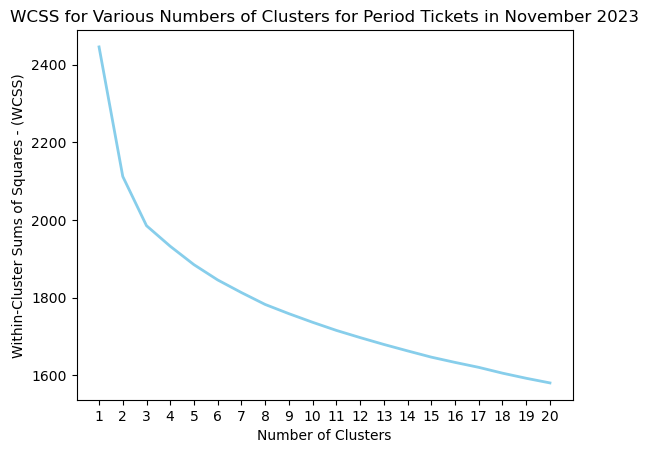

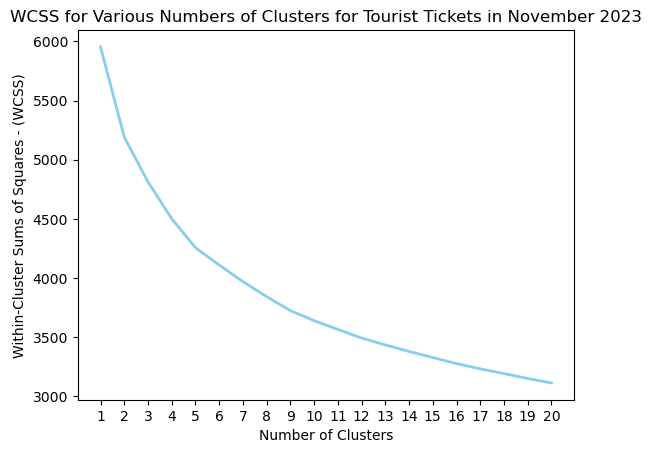

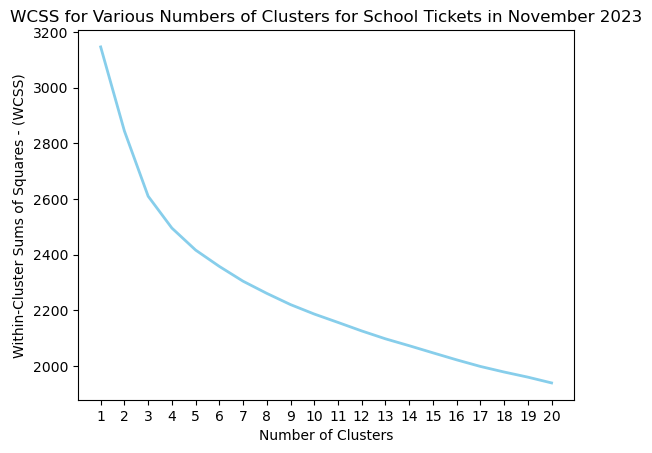

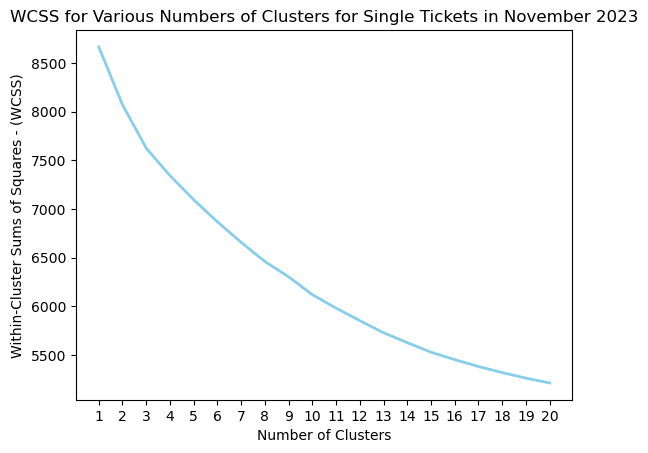

In [18]:
range_n_clusters = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] 

X1, _ = one_cluster_samples['Period'] # (X, Y)
X2, _ = one_cluster_samples['Tourist']
X3, _ = one_cluster_samples['School']
X4, _ = one_cluster_samples['Single']

gmm_pick(X1, range_n_clusters, "Period", TIME_PERIODS_NAME[P1]) 
gmm_pick(X2, range_n_clusters, "Tourist", TIME_PERIODS_NAME[P1])
gmm_pick(X3, range_n_clusters, "School", TIME_PERIODS_NAME[P1])
gmm_pick(X4, range_n_clusters, "Single", TIME_PERIODS_NAME[P1])

StatementMeta(dslsmall, 489, 25, Finished, Available)

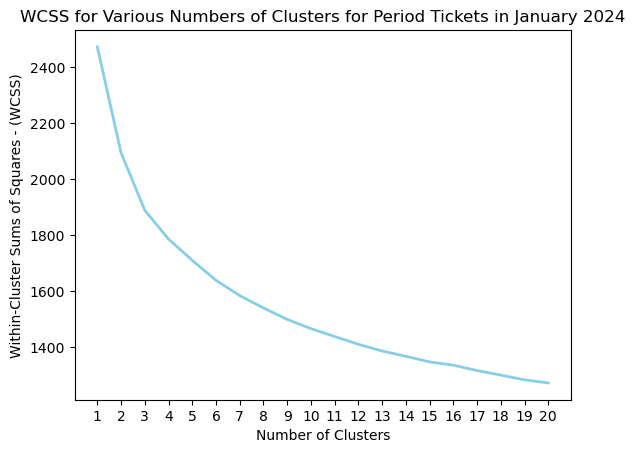

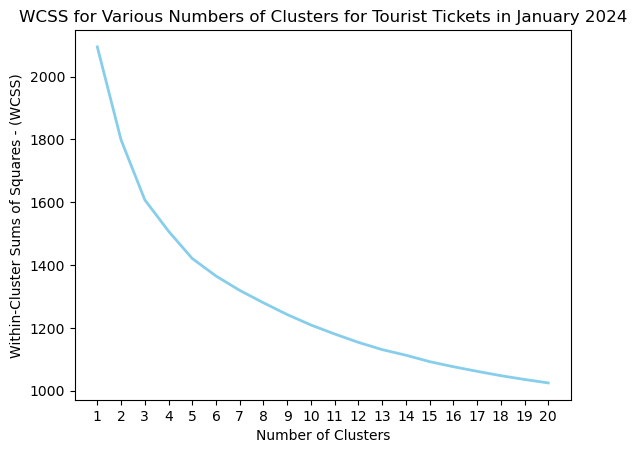

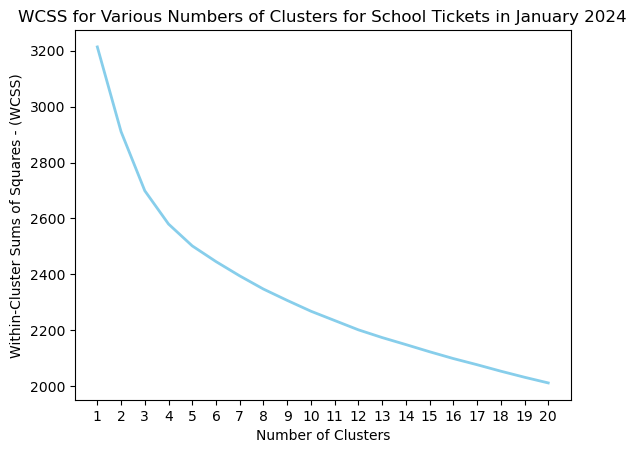

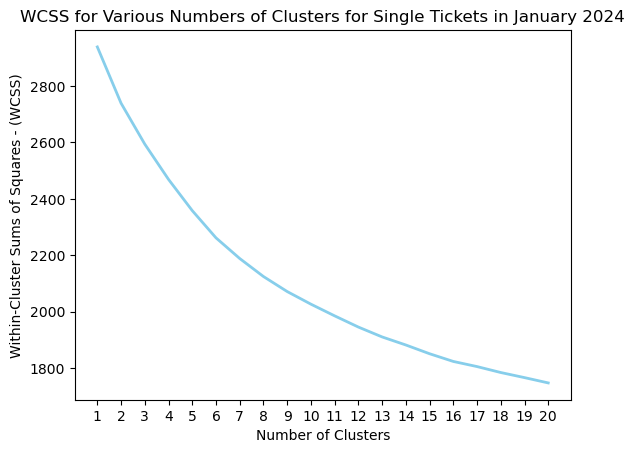

In [24]:
range_n_clusters = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] 

X1, _ = two_cluster_samples['Period'] # (X, Y)
X2, _ = two_cluster_samples['Tourist']
X3, _ = two_cluster_samples['School']
X4, _ = two_cluster_samples['Single']

gmm_pick(X1, range_n_clusters, "Period", TIME_PERIODS_NAME[P2]) 
gmm_pick(X2, range_n_clusters, "Tourist", TIME_PERIODS_NAME[P2])
gmm_pick(X3, range_n_clusters, "School", TIME_PERIODS_NAME[P2])
gmm_pick(X4, range_n_clusters, "Single", TIME_PERIODS_NAME[P2])

In [242]:
# Select the number of clusters for each ticket category
CLUSTERING_PARAMETERS = {'Period': 6, 'Tourist': 6, 'School': 5, 'Single': 9} 

StatementMeta(dslsmall, 491, 243, Finished, Available)

### Cluster Groups

In [243]:
# For period one
X1, Y1 = one_cluster_samples['Period'] # (X, Y) Y = ["CardKey"]
X2, Y2 = one_cluster_samples['Tourist']
X3, Y3 = one_cluster_samples['School']
X4, Y4 = one_cluster_samples['Single']

Y1 = cluster_manual_group(X1, Y1, CLUSTERING_PARAMETERS["Period"]) # (X, Y) Y = ["CardKey", "Class"]
Y2 = cluster_manual_group(X2, Y2, CLUSTERING_PARAMETERS["Tourist"])
Y3 = cluster_manual_group(X3, Y3, CLUSTERING_PARAMETERS["School"])
Y4 = cluster_manual_group(X4, Y4, CLUSTERING_PARAMETERS["Single"])

X_list_one = [X1.copy(), X2.copy(), X3.copy(), X4.copy()]
Y_list_one = [Y1.copy(), Y2.copy(), Y3.copy(), Y4.copy()]

StatementMeta(dslsmall, 491, 244, Finished, Available)

In [244]:
# For period two
X1, Y1 = two_cluster_samples['Period'] # (X, Y) Y = ["CardKey"]
X2, Y2 = two_cluster_samples['Tourist']
X3, Y3 = two_cluster_samples['School']
X4, Y4 = two_cluster_samples['Single']

Y1 = cluster_manual_group(X1, Y1, CLUSTERING_PARAMETERS["Period"]) # (X, Y) Y = ["CardKey"]
Y2 = cluster_manual_group(X2, Y2, CLUSTERING_PARAMETERS["Tourist"])
Y3 = cluster_manual_group(X3, Y3, CLUSTERING_PARAMETERS["School"])
Y4 = cluster_manual_group(X4, Y4, CLUSTERING_PARAMETERS["Single"])

X_list_two = [X1.copy(), X2.copy(), X3.copy(), X4.copy()]
Y_list_two = [Y1.copy(), Y2.copy(), Y3.copy(), Y4.copy()]

StatementMeta(dslsmall, 491, 245, Finished, Available)

## 6. Cluster refinement

### Combine all groups from all the ticket categories back into a single dataframe after relabeling for each ticket category

In [246]:
# Initialize DataFrames to store combined clusters
combined_Y_one = pd.DataFrame()
combined_Y_two = pd.DataFrame()

# Combine the clusters from different groups into one DataFrame
for group_num in range(4):
    combined_Y_one = pd.concat([combined_Y_one, Y_list_one[group_num]], ignore_index=True)
    combined_Y_two = pd.concat([combined_Y_two, Y_list_two[group_num]], ignore_index=True)

combined_X_one = pd.DataFrame()
combined_X_two = pd.DataFrame()

# Combine the features from different groups into one DataFrame
for group_num in range(4):
    combined_X_one = pd.concat([combined_X_one, X_list_one[group_num]], ignore_index=True)
    combined_X_two = pd.concat([combined_X_two, X_list_two[group_num]], ignore_index=True)

# Ensure the Class labels are matched correctly to their corresponding features
combined_one = combined_X_one.copy()
combined_two = combined_X_two.copy()

combined_one["Class"] = combined_Y_one["Class"]
combined_two["Class"] = combined_Y_two["Class"]

StatementMeta(dslsmall, 491, 247, Finished, Available)

In [248]:
combined_X_one_spread = combined_X_one.copy()
combined_X_one_spread["Class"] = combined_Y_one["Class"]
combined_X_two_spread = combined_X_two.copy()
combined_X_two_spread["Class"] = combined_Y_two["Class"]

StatementMeta(dslsmall, 491, 249, Finished, Available)

### Apply hierarchical agglomerative clustering (HAC) to acquire a final set of reduced temporal profiles

In [251]:
# Compute pairwise distances between centroids
centroids_one = combined_one.groupby('Class').mean() # combined_X_one + "Class"
centroids_two = combined_two.groupby('Class').mean()
dist_matrix_one = pdist(centroids_one, metric='euclidean')
dist_matrix_two = pdist(centroids_two, metric='euclidean')

# Perform hierarchical clustering
Z_one = linkage(dist_matrix_one, method='ward') # complete, ward, average, ...?
Z_two = linkage(dist_matrix_two, method='ward') # 

StatementMeta(dslsmall, 491, 252, Finished, Available)

StatementMeta(dslsmall, 491, 253, Finished, Available)

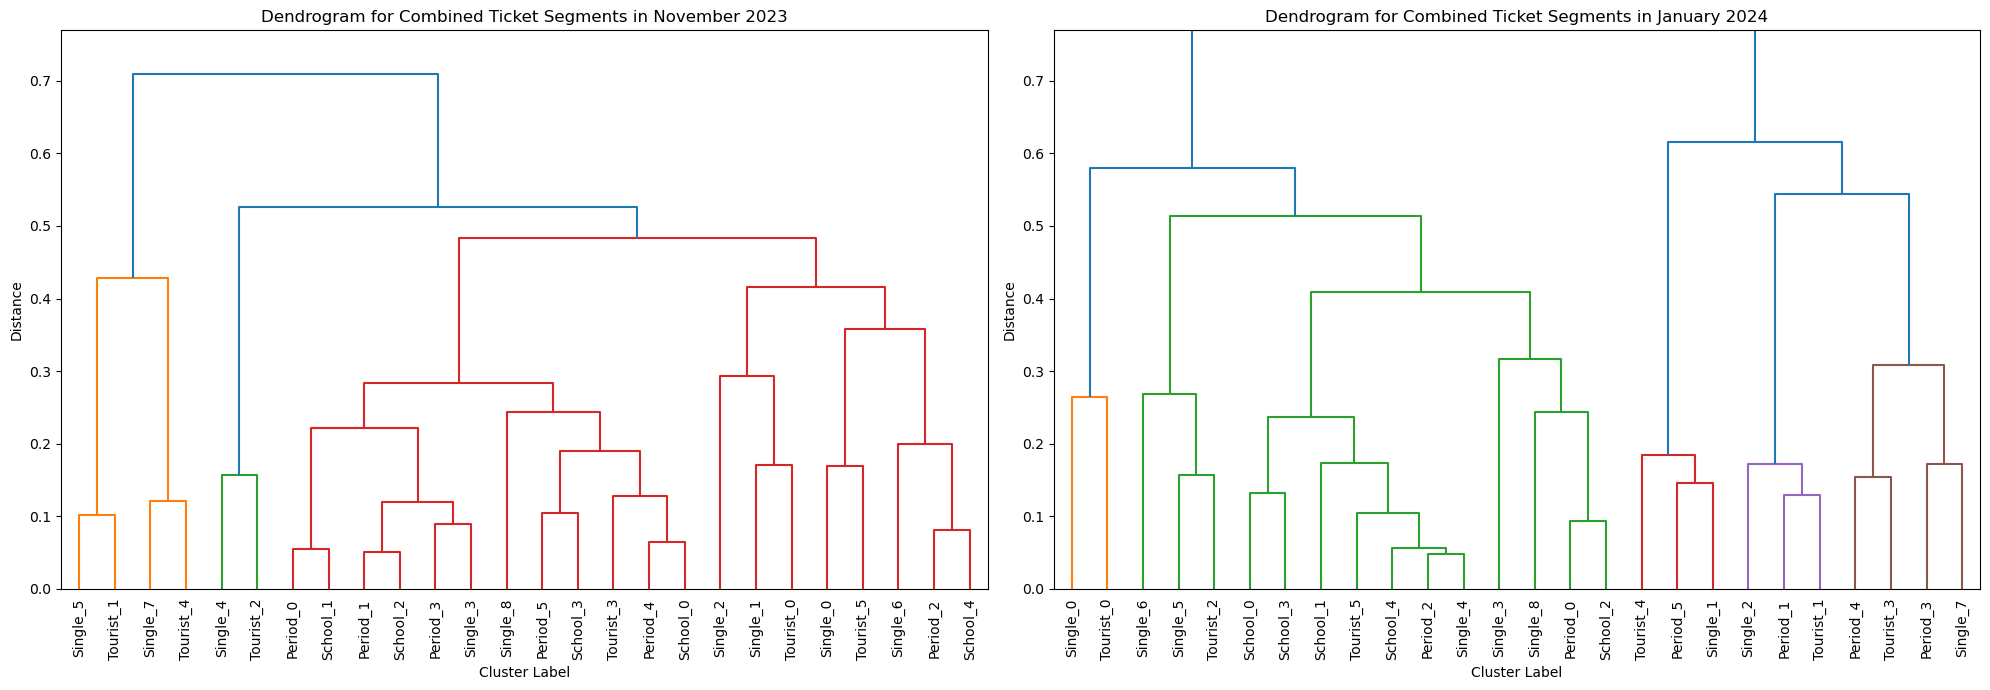

In [252]:
max_d_one = max(dendrogram(Z_one, no_plot=True)['dcoord'], key=lambda x: max(x))
max_d_two = max(dendrogram(Z_two, no_plot=True)['dcoord'], key=lambda x: max(x))
max_distance = max(max(max_d_one), max(max_d_two))

# Plot dendrograms for both periods
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# Plot dendrogram for Period 1
dendrogram(Z_one, labels=centroids_one.index, ax=axes[0])
axes[0].set_title(f'Dendrogram for Combined Ticket Segments in {TIME_PERIODS_NAME[P1]}')
axes[0].set_xlabel('Cluster Label')
axes[0].set_ylabel('Distance')
axes[0].tick_params(axis='x', rotation=90)
axes[0].set_ylim(0, max_distance)

# Plot dendrogram for Period 2
dendrogram(Z_two, labels=centroids_two.index, ax=axes[1])
axes[1].set_title(f'Dendrogram for Combined Ticket Segments in {TIME_PERIODS_NAME[P2]}')
axes[1].set_xlabel('Cluster Label')
axes[1].set_ylabel('Distance')
axes[1].tick_params(axis='x', rotation=90)
axes[1].set_ylim(0, max_distance)

plt.tight_layout()
plt.show()

### Pick the final number of clusters to keep

In [177]:
# Determine the number of clusters
num_clusters_one = 6 # P1
num_clusters_two = 6 # P2

StatementMeta(dslsmall, 491, 178, Finished, Available)

In [253]:
# Generate new labels based on the hierarchical clustering
new_labels_one = fcluster(Z_one, num_clusters_one, criterion='maxclust')
new_labels_two = fcluster(Z_two, num_clusters_two, criterion='maxclust')

# Create new cluster mappings
new_cluster_map_one = {old_label: new_label for old_label, new_label in zip(centroids_one.index, new_labels_one)}
new_cluster_map_two = {old_label: new_label for old_label, new_label in zip(centroids_two.index, new_labels_two)}

# Update the Class column with new labels
combined_Y_one['Class'] = combined_Y_one['Class'].map(new_cluster_map_one)
combined_Y_two['Class'] = combined_Y_two['Class'].map(new_cluster_map_two)

StatementMeta(dslsmall, 491, 254, Finished, Available)

## 7. Cluster mapping
Match and relabel clusters based on the Jaccard similarity using CardKeys between P1 and P2

### Look at sizes of these final clusters for inital evaluation

StatementMeta(dslsmall, 491, 255, Finished, Available)

November 2023 vs. January 2024
Group Sizes and Percentages for November 2023:
1: 13064 users, 6.23% of total
2: 9696 users, 4.62% of total
3: 6981 users, 3.33% of total
4: 129164 users, 61.60% of total
5: 22103 users, 10.54% of total
6: 28667 users, 13.67% of total
Group Sizes and Percentages for November 2023:
1: 3040 users, 2.72% of total
2: 5211 users, 4.67% of total
3: 67762 users, 60.67% of total
4: 13710 users, 12.27% of total
5: 4999 users, 4.48% of total
6: 5494 users, 4.92% of total
7: 11480 users, 10.28% of total


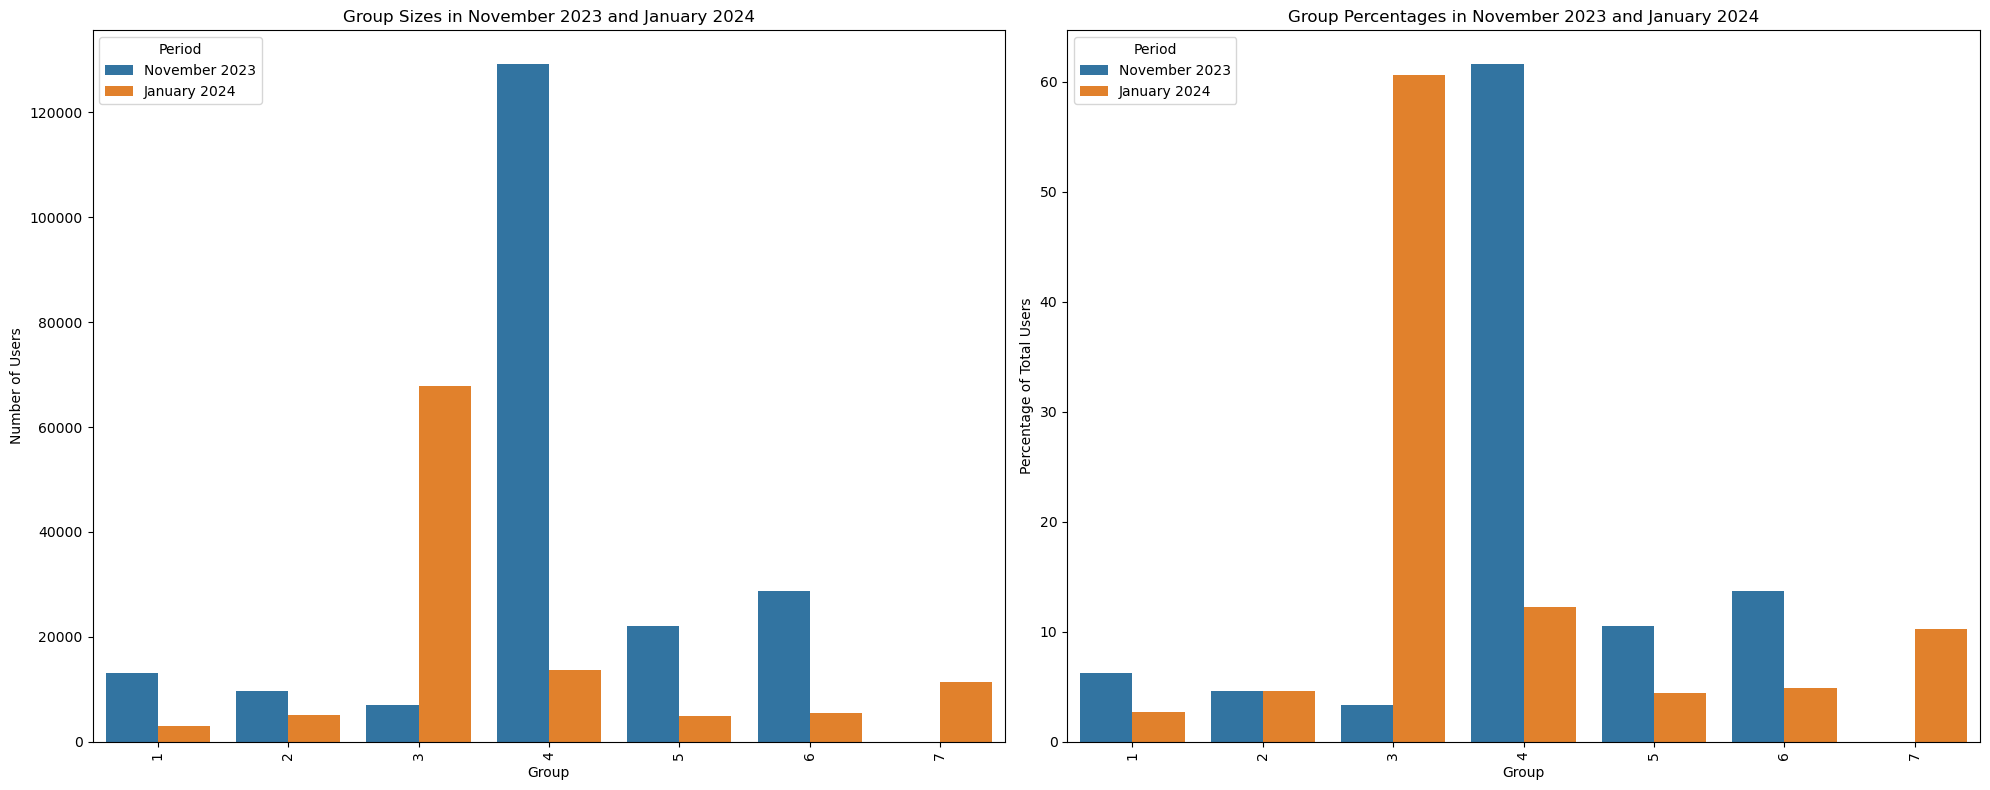

In [254]:
# Calculate sizes and percentages for both periods
def calculate_group_stats(combined_data):
    group_sizes = combined_data['Class'].value_counts().sort_index()
    total_users = combined_data['CardKey'].nunique()
    group_percentages = (group_sizes / total_users) * 100
    return group_sizes, group_percentages

group_sizes_one, group_percentages_one = calculate_group_stats(combined_Y_one)
group_sizes_two, group_percentages_two = calculate_group_stats(combined_Y_two)

print(f"{TIME_PERIODS_NAME[P1]} vs. {TIME_PERIODS_NAME[P2]}")
print(f"Group Sizes and Percentages for {TIME_PERIODS_NAME[P1]}:")
for group, size in group_sizes_one.items():
    percentage = group_percentages_one[group]
    print(f"{group}: {size} users, {percentage:.2f}% of total")

print(f"Group Sizes and Percentages for {TIME_PERIODS_NAME[P1]}:")
for group, size in group_sizes_two.items():
    percentage = group_percentages_two[group]
    print(f"{group}: {size} users, {percentage:.2f}% of total")

# Combine data for plotting
df_one = pd.DataFrame({
    'Group': group_sizes_one.index,
    'Users': group_sizes_one.values,
    'Percentage': group_percentages_one.values,
    'Period': TIME_PERIODS_NAME[P1]
})

df_two = pd.DataFrame({
    'Group': group_sizes_two.index,
    'Users': group_sizes_two.values,
    'Percentage': group_percentages_two.values,
    'Period': TIME_PERIODS_NAME[P2]
})

combined_df = pd.concat([df_one, df_two])

# Plotting the data
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot group sizes
sns.barplot(ax=axes[0], x='Group', y='Users', hue='Period', data=combined_df)
axes[0].set_title(f'Group Sizes in {TIME_PERIODS_NAME[P1]} and {TIME_PERIODS_NAME[P2]}')
axes[0].set_ylabel('Number of Users')
axes[0].tick_params(axis='x', rotation=90)

sns.barplot(ax=axes[1], x='Group', y='Percentage', hue='Period', data=combined_df)
axes[1].set_title(f'Group Percentages in {TIME_PERIODS_NAME[P1]} and {TIME_PERIODS_NAME[P2]}')
axes[1].set_ylabel('Percentage of Total Users')
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

### Match groups based on CardKey using Jaccard similarity and relabel clusters

In [256]:
# Get unique classes
clusters_Y1 = combined_Y_one['Class'].unique()
clusters_Y2 = combined_Y_two['Class'].unique()

# Find common users (CardKeys) between the two periods
common_users = set(combined_Y_one['CardKey']).intersection(set(combined_Y_two['CardKey']))

FULL_MATCH = False # Match only for users that exist in both periods, mainly for Tourist tickets

StatementMeta(dslsmall, 491, 257, Finished, Available)

In [257]:
if FULL_MATCH:
    # Create sets of CardKeys for each cluster
    cluster_sets_Y1 = {cls: set(combined_Y_one[combined_Y_one['Class'] == cls]['CardKey']) for cls in clusters_Y1}
    cluster_sets_Y2 = {cls: set(combined_Y_two[combined_Y_two['Class'] == cls]['CardKey']) for cls in clusters_Y2}
else:
    print("Only matching with users that exist in both periods")
    # Filter the combined_Y_one and combined_Y_two DataFrames to only include common users
    filtered_Y_one = combined_Y_one[combined_Y_one['CardKey'].isin(common_users)]
    filtered_Y_two = combined_Y_two[combined_Y_two['CardKey'].isin(common_users)]

    # Create sets of CardKeys for each cluster for the filtered data
    cluster_sets_Y1 = {cls: set(filtered_Y_one[filtered_Y_one['Class'] == cls]['CardKey']) for cls in clusters_Y1}
    cluster_sets_Y2 = {cls: set(filtered_Y_two[filtered_Y_two['Class'] == cls]['CardKey']) for cls in clusters_Y2}

StatementMeta(dslsmall, 491, 258, Finished, Available)

Only matching with users that exist in both periods


In [258]:
# Initialize a matrix to store Jaccard similarities
jaccard_matrix = pd.DataFrame(index=clusters_Y1, columns=clusters_Y2, dtype=float)

# Compute Jaccard similarities
for cls1, set1 in cluster_sets_Y1.items():
    for cls2, set2 in cluster_sets_Y2.items():
        intersection = len(set1.intersection(set2))
        union = len(set1.union(set2))
        jaccard_matrix.loc[cls1, cls2] = intersection / union

StatementMeta(dslsmall, 491, 259, Finished, Available)

StatementMeta(dslsmall, 491, 260, Finished, Available)

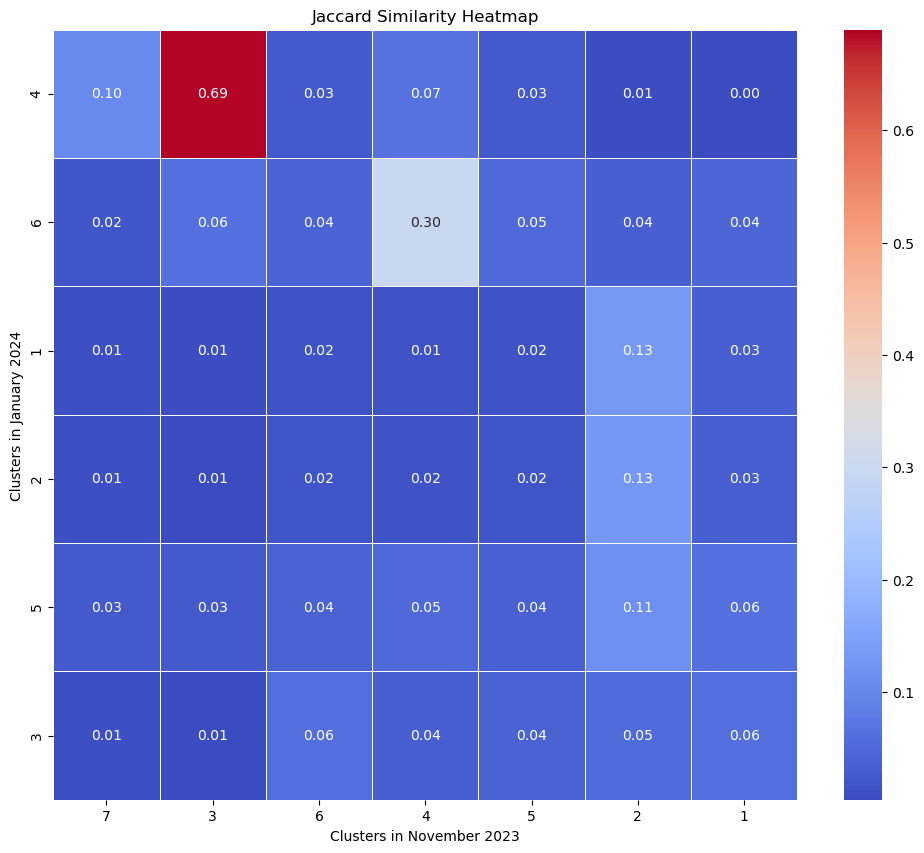

In [259]:
# Visualize the Jaccard similarity matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(jaccard_matrix, annot=True, cmap='coolwarm', linewidths=.5, fmt='.2f')
plt.title('Jaccard Similarity Heatmap')
plt.xlabel(f'Clusters in {TIME_PERIODS_NAME[P1]}')
plt.ylabel(f'Clusters in {TIME_PERIODS_NAME[P2]}')
plt.show()

### Relabel clusters based on most similar cluster, but one cluster can only be mapped to/from once
Could further be configured to allow for splitting and merging of clusters over time e.g. map from n:m or m:n

In [260]:
# Initialize a dictionary to store the best matches
best_matches = {}

# Create a copy of the Jaccard matrix to manipulate
jaccard_matrix_copy = jaccard_matrix.copy()

# Find the best matches
for _ in range(len(jaccard_matrix)):
    # Find the maximum value in the Jaccard matrix
    max_idx = jaccard_matrix_copy.stack().idxmax()
    best_match_Y1, best_match_Y2 = max_idx
    
    # Store the best match
    best_matches[best_match_Y2] = best_match_Y1
    
    # Set the row and column of the best match to -1 to exclude them from further matches
    jaccard_matrix_copy.loc[best_match_Y1, :] = -1
    jaccard_matrix_copy.loc[:, best_match_Y2] = -1

print(best_matches)

# Rename the labels in combined_Y_two
combined_Y_two['Class'] = combined_Y_two['Class'].map(best_matches)

StatementMeta(dslsmall, 491, 261, Finished, Available)

{3: 4, 4: 6, 2: 1, 1: 5, 6: 3, 5: 2}


/tmp/ipykernel_17716/2864673692.py:18: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  jaccard_matrix_copy.loc[:, best_match_Y2] = -1


## 8. Evaluation and Analysis

In [261]:
def calculate_size_changes(clustered_data_one, clustered_data_two):
    # Calculate the size of each cluster in both periods
    size_one = clustered_data_one.groupby('Class')['CardKey'].nunique().sort_index()
    size_two = clustered_data_two.groupby('Class')['CardKey'].nunique().sort_index()

    size_changes = pd.DataFrame({
        'Cluster': size_one.index,
        'Size P1': size_one.values,
        'Size P2': size_two.reindex(size_one.index, fill_value=0).values
    })
    size_changes['Size Change'] = size_changes['Size P2'] - size_changes['Size P1']
    
    return size_changes

def track_user_movements(clustered_data_one, clustered_data_two):
    # Create a DataFrame to track user movements
    movements = []

    for cluster_one in clustered_data_one['Class'].unique():
        users_one = set(clustered_data_one[clustered_data_one['Class'] == cluster_one]['CardKey'])

        for cluster_two in clustered_data_two['Class'].unique():
            users_two = set(clustered_data_two[clustered_data_two['Class'] == cluster_two]['CardKey'])

            common_users = users_one.intersection(users_two)
            movements.append({
                'From Cluster': cluster_one,
                'To Cluster': cluster_two,
                'Number of Users': len(common_users)
            })

    movements_df = pd.DataFrame(movements)
    return movements_df

def quantify_changes(clustered_data_one, clustered_data_two):
    changes = []

    for cluster in clustered_data_one['Class'].unique():
        cluster_one_data = clustered_data_one[clustered_data_one['Class'] == cluster]
        cluster_two_data = clustered_data_two[clustered_data_two['Class'] == cluster]

        user_count_one = cluster_one_data["CardKey"].nunique()
        user_count_two = cluster_two_data["CardKey"].nunique()

        avg_trips_one = len(cluster_one_data) / user_count_one if user_count_one > 0 else -1
        avg_trips_two = len(cluster_two_data) / user_count_two if user_count_two > 0 else -1

        #avg_distance_one = cluster_one_data['JourneyDistanceKm'].mean()
        #avg_distance_two = cluster_two_data['JourneyDistanceKm'].mean()

        changes.append({
            'Cluster': cluster,
            'Avg Trips P1': avg_trips_one,
            'Avg Trips P2': avg_trips_two,
            'Change in Avg Trips': avg_trips_two - avg_trips_one,
            #'Avg Distance P1': avg_distance_one,
            #'Avg Distance P2': avg_distance_two,
            #'Change in Avg Distance': avg_distance_two - avg_distance_one
        })

    changes_df = pd.DataFrame(changes)
    return changes_df

StatementMeta(dslsmall, 491, 262, Finished, Available)

## Merge cluster labels to CardKeys from the original dataframes to get all journes for each cluster

In [262]:
# Merge the cluster labels with the original data
clustered_data_one = pd.merge(original_one_pdf, combined_Y_one, on="CardKey", how="inner")
clustered_data_two = pd.merge(original_two_pdf, combined_Y_two, on="CardKey", how="inner")

# Ensure 'DayOfWeek' is a categorical type with a logical order
clustered_data_one['DayOfWeek'] = pd.Categorical(clustered_data_one['DayOfWeek'], categories=DAYS_ORDER, ordered=True)
clustered_data_two['DayOfWeek'] = pd.Categorical(clustered_data_two['DayOfWeek'], categories=DAYS_ORDER, ordered=True)

StatementMeta(dslsmall, 491, 263, Finished, Available)

In [263]:
print(len(clustered_data_one))
print(len(clustered_data_two))

StatementMeta(dslsmall, 491, 264, Finished, Available)

5449195
2548477


### Showcase the size differences between clusters over time where the time periods may have more or fewer users 

In [264]:
#analyze_clusters(clustered_data_one, clustered_data_two)
size_changes_df = calculate_size_changes(clustered_data_one, clustered_data_two)
print(size_changes_df)

StatementMeta(dslsmall, 491, 265, Finished, Available)

   Cluster  Size P1  Size P2  Size Change
0        1    13064     5211        -7853
1        2     9696     4999        -4697
2        3     6981     5494        -1487
3        4   129164    67762       -61402
4        5    22103     3040       -19063
5        6    28667    13710       -14957


### Look at how users moved from clusters to other clusters with time (only works for users that traveled in both periods)

In [266]:
user_movements_df = track_user_movements(clustered_data_one, clustered_data_two)

# Filter rows where 'Number of Users' is greater than 0
filtered_user_movements = user_movements_df[user_movements_df['Number of Users'] > 250] # Filter to not print all group movements

# Print the filtered rows
print("From Cluster   To Cluster   Number of Users")
for index, row in filtered_user_movements.iterrows():
    print(f"{row['From Cluster']:>12} {row['To Cluster']:>12} {row['Number of Users']:>17}")

StatementMeta(dslsmall, 491, 267, Finished, Available)

From Cluster   To Cluster   Number of Users
         6.0          4.0            4452.0
         6.0          2.0             848.0
         6.0          6.0            6377.0
         6.0          3.0             749.0
         6.0          5.0             680.0
         6.0          1.0             604.0
         4.0          4.0           56901.0
         4.0          2.0            2013.0
         4.0          6.0            5450.0
         4.0          3.0            2042.0
         4.0          5.0             299.0
         4.0          1.0             523.0
         5.0          4.0            1753.0
         5.0          2.0             298.0
         5.0          6.0             887.0
         5.0          3.0             329.0
         5.0          5.0             386.0
         5.0          1.0             842.0
         3.0          4.0             354.0
         3.0          6.0             544.0
         3.0          3.0             319.0
         3.0          1.0       

In [267]:
# Look at the mean/average travel behaviors for these clusters (can add more such as frequency, distance if wanted, but need to add in query too)
quantified_changes_df = quantify_changes(clustered_data_one, clustered_data_two)
print(quantified_changes_df)

StatementMeta(dslsmall, 491, 268, Finished, Available)

   Cluster  Avg Trips P1  Avg Trips P2  Change in Avg Trips
0        6     19.641713     22.264478             2.622765
1        4     33.648130     29.258582            -4.389548
2        5     11.656201      9.205592            -2.450608
3        3      9.917920      8.351474            -1.566446
4        1     10.070040     10.427173             0.357133
5        2      8.412748      8.374875            -0.037873


In [229]:
def plot_cluster_patterns(clustered_data_one, clustered_data_two, cluster_label, max_day_y, max_hour_y):
    # Filter data for the current cluster from both periods
    cluster_data_one = clustered_data_one[clustered_data_one['Class'] == cluster_label]
    cluster_data_two = clustered_data_two[clustered_data_two['Class'] == cluster_label]
    
    user_count_one = cluster_data_one['CardKey'].nunique()
    user_count_two = cluster_data_two['CardKey'].nunique()
    
    fig, axes = plt.subplots(1, 4, figsize=(24, 6))  # Adjust overall figure size as needed
    
    # Plot 1: Average trips per weekday for period one
    day_plot_one = cluster_data_one.groupby('DayOfWeek').size() / user_count_one
    sns.barplot(ax=axes[0], x=day_plot_one.index, y=day_plot_one.values, order=DAYS_ORDER, color='blue')
    axes[0].set_title(f'{TIME_PERIODS_NAME[P1]}: Avg Journeys per Weekday for Cluster {cluster_label}')
    axes[0].set_ylabel('Average Number of Journeys')
    axes[0].set_xlabel('Day of the Week')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].set_ylim(0, max_day_y)
    
    # Plot 2: Average trips made per hour of the day for period one
    hour_plot_one = cluster_data_one.groupby('InHour').size() / user_count_one
    sns.barplot(ax=axes[1], x=hour_plot_one.index, y=hour_plot_one.values, color='green')
    axes[1].set_title(f'{TIME_PERIODS_NAME[P1]}: Avg Journeys per Hour of the Day for Cluster {cluster_label}')
    axes[1].set_ylabel('Average Number of Journeys')
    axes[1].set_xlabel('Hour of the Day')
    axes[1].set_xticks(range(0, 24))  # Ensure x-ticks cover each hour
    axes[1].set_ylim(0, max_hour_y)
    
    # Plot 3: Average trips per weekday for period two
    day_plot_two = cluster_data_two.groupby('DayOfWeek').size() / user_count_two
    sns.barplot(ax=axes[2], x=day_plot_two.index, y=day_plot_two.values, order=DAYS_ORDER, color='blue')
    axes[2].set_title(f'{TIME_PERIODS_NAME[P2]}: Avg Journeys per Weekday for Cluster {cluster_label}')
    axes[2].set_ylabel('Average Number of Journeys')
    axes[2].set_xlabel('Day of the Week')
    axes[2].tick_params(axis='x', rotation=45)
    axes[2].set_ylim(0, max_day_y)
    
    # Plot 4: Average trips made per hour of the day for period two
    hour_plot_two = cluster_data_two.groupby('InHour').size() / user_count_two
    sns.barplot(ax=axes[3], x=hour_plot_two.index, y=hour_plot_two.values, color='green')
    axes[3].set_title(f'{TIME_PERIODS_NAME[P2]}: Avg Journeys per Hour of the Day for Cluster {cluster_label}')
    axes[3].set_ylabel('Average Number of Journeys')
    axes[3].set_xlabel('Hour of the Day')
    axes[3].set_xticks(range(0, 24))  # Ensure x-ticks cover each hour
    axes[3].set_ylim(0, max_hour_y)
    
    plt.tight_layout()
    plt.show()

def calculate_max_y(clustered_data_one, clustered_data_two, cluster_label):
    cluster_data_one = clustered_data_one[clustered_data_one['Class'] == cluster_label]
    cluster_data_two = clustered_data_two[clustered_data_two['Class'] == cluster_label]

    user_count_one = cluster_data_one['CardKey'].nunique()
    user_count_two = cluster_data_two['CardKey'].nunique()

    day_max_one = (cluster_data_one.groupby('DayOfWeek').size() / user_count_one).max()
    hour_max_one = (cluster_data_one.groupby('InHour').size() / user_count_one).max()

    day_max_two = (cluster_data_two.groupby('DayOfWeek').size() / user_count_two).max()
    hour_max_two = (cluster_data_two.groupby('InHour').size() / user_count_two).max()

    max_day_y = max(day_max_one, day_max_two)
    max_hour_y = max(hour_max_one, hour_max_two)
    
    return max_day_y, max_hour_y

def visualize_clusters(clustered_data_one, clustered_data_two):
    unique_clusters = clustered_data_one["Class"].unique()
    for label in unique_clusters:
        max_day_y, max_hour_y = calculate_max_y(clustered_data_one, clustered_data_two, label)
        plot_cluster_patterns(clustered_data_one, clustered_data_two, label, max_day_y, max_hour_y)


StatementMeta(dslsmall, 491, 230, Finished, Available)

### Visializes the temporal profiles for each cluster with P1 on the left and P2 on the right for the matched clusters on each row.

StatementMeta(dslsmall, 491, 269, Finished, Available)

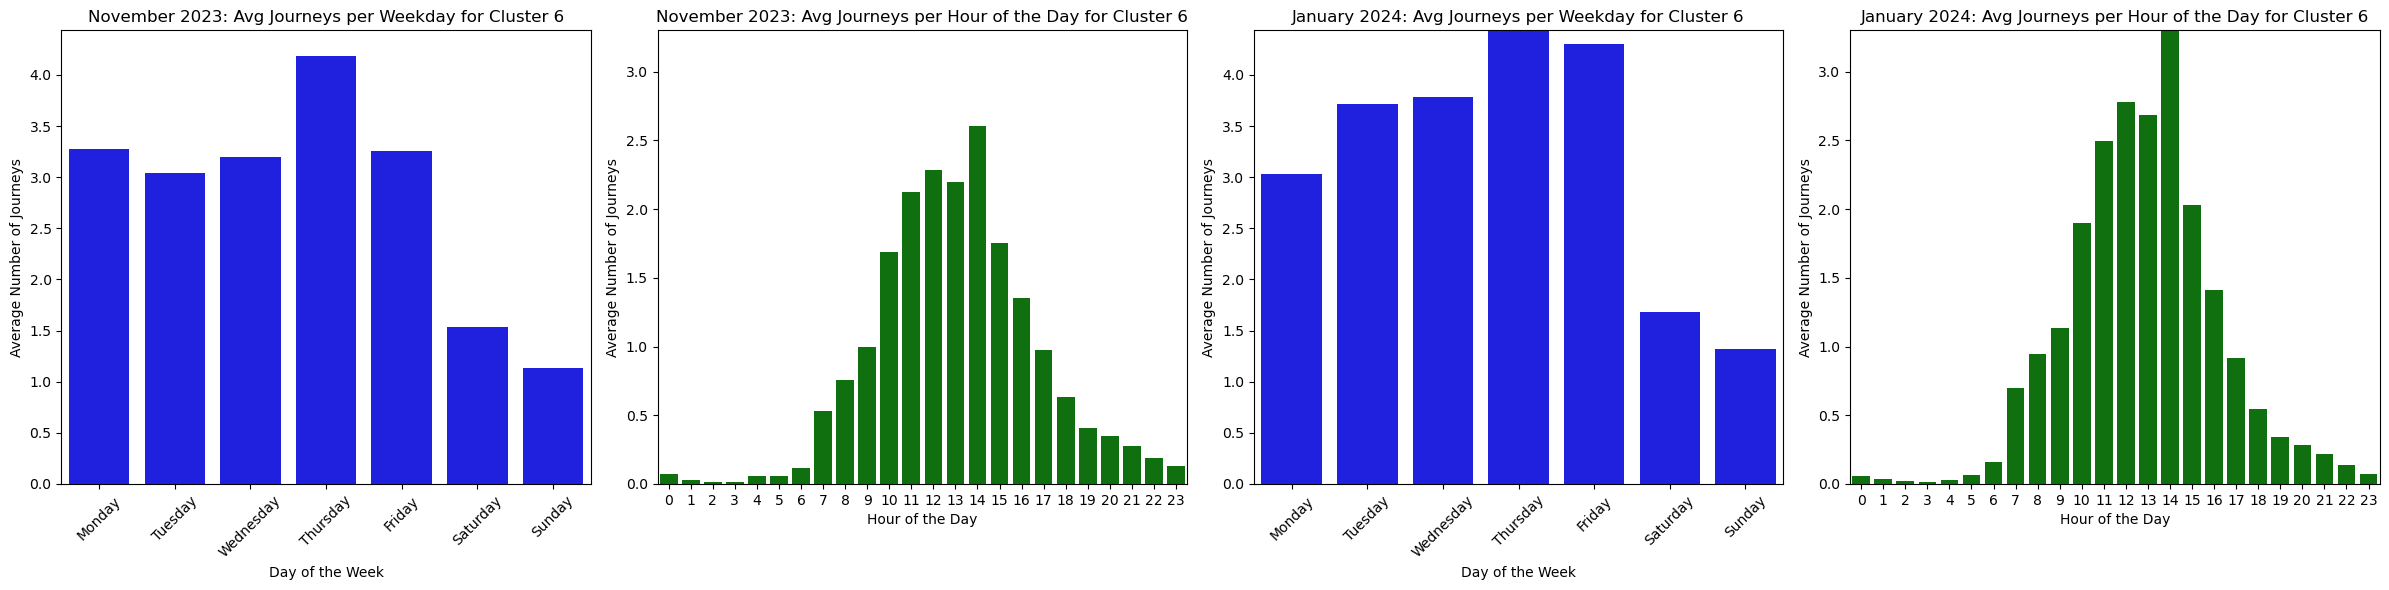

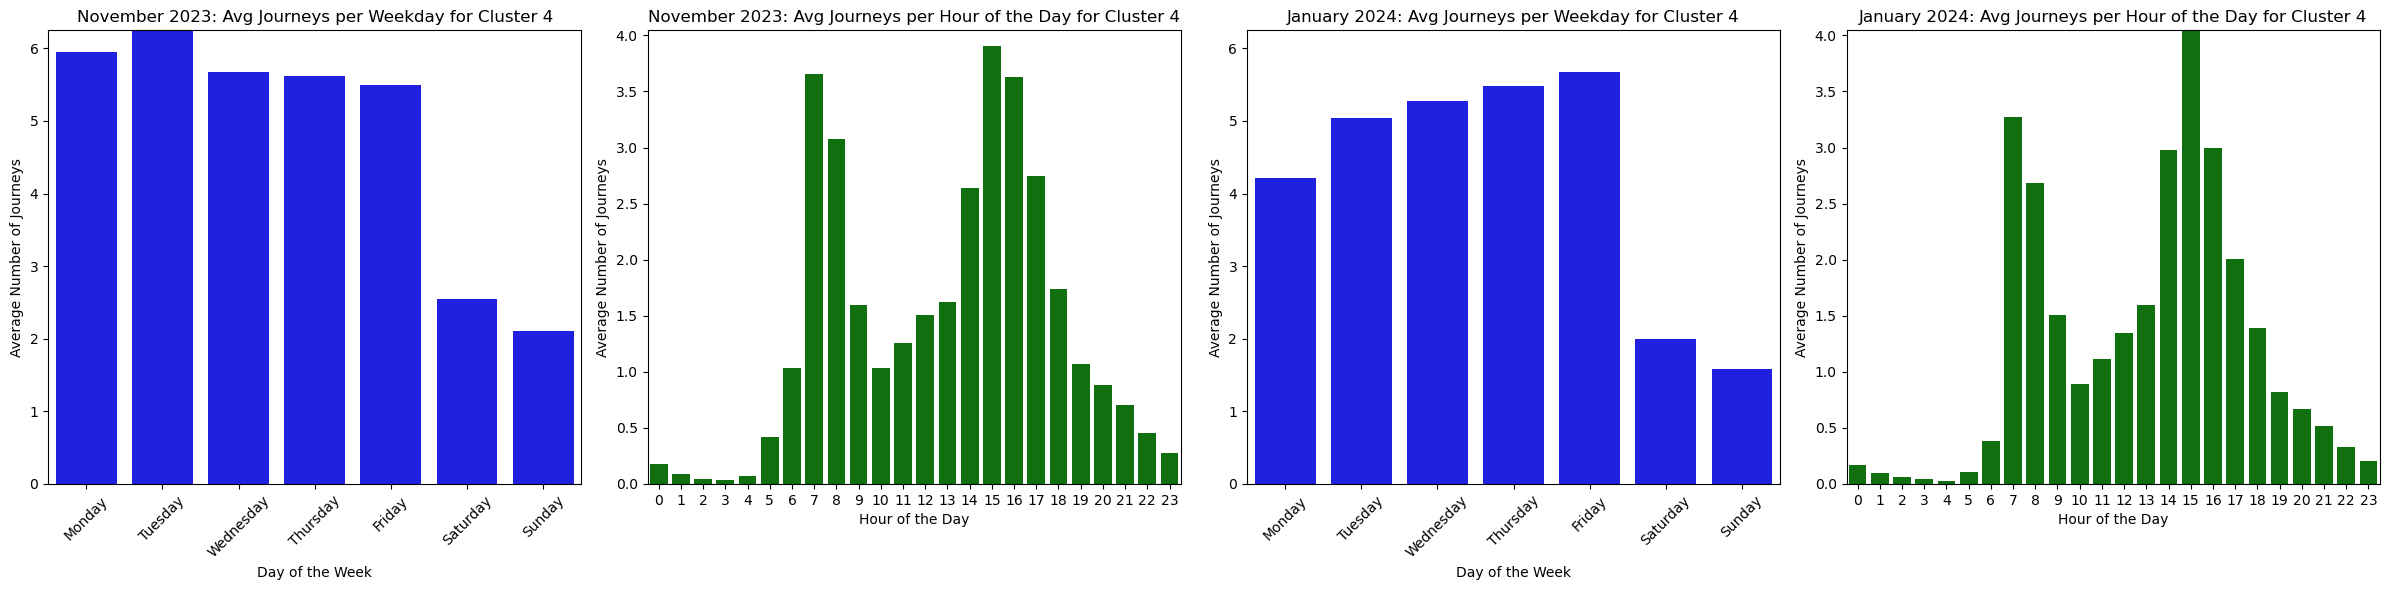

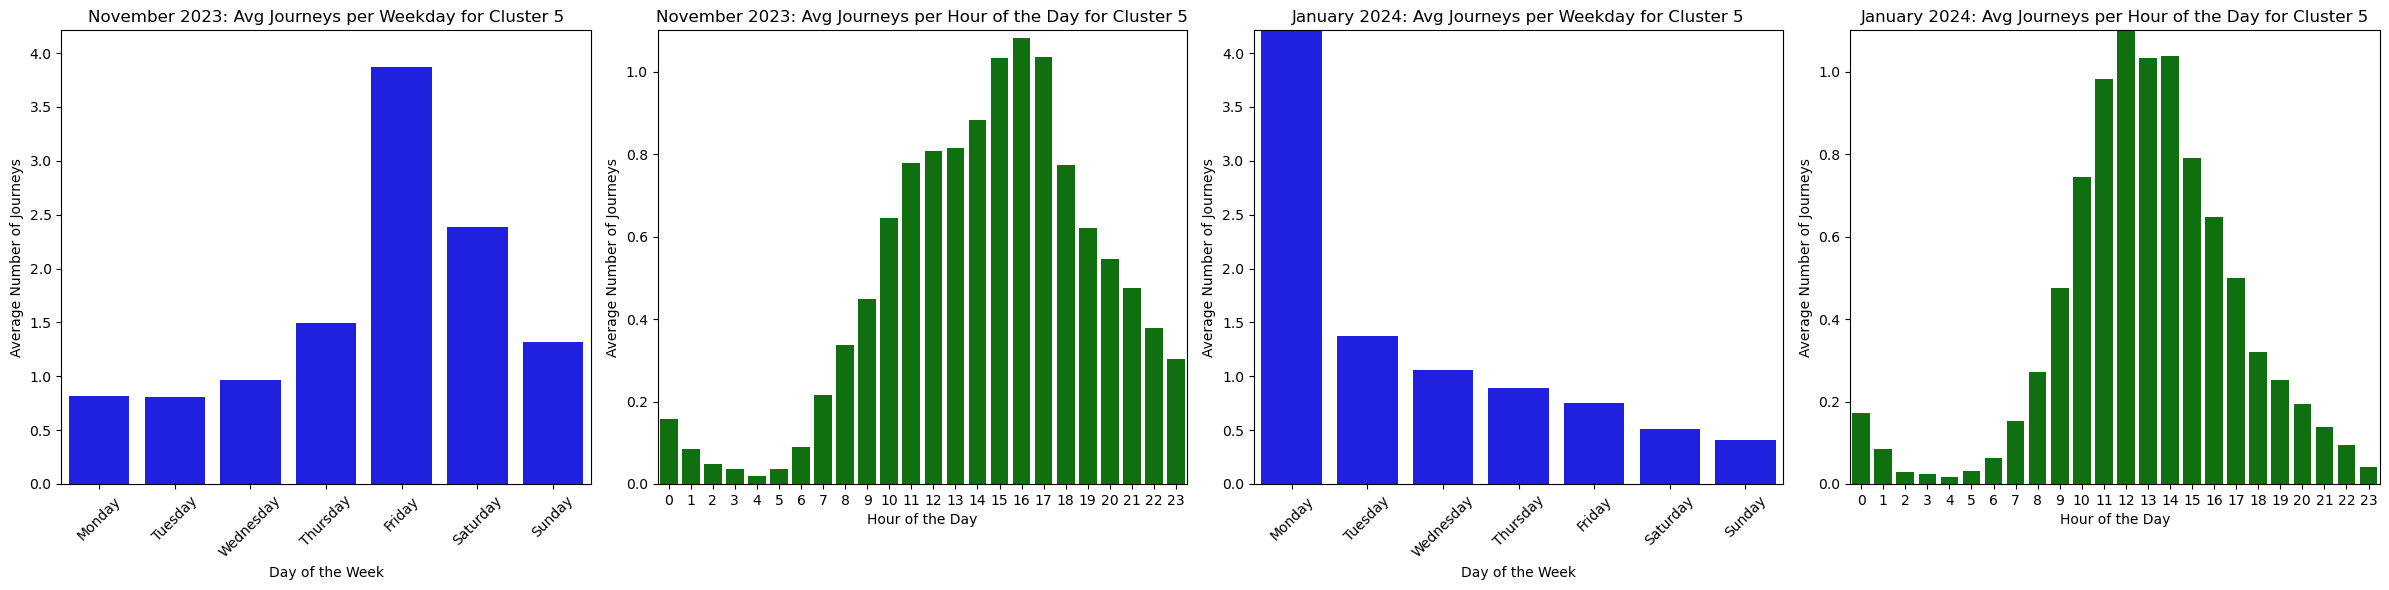

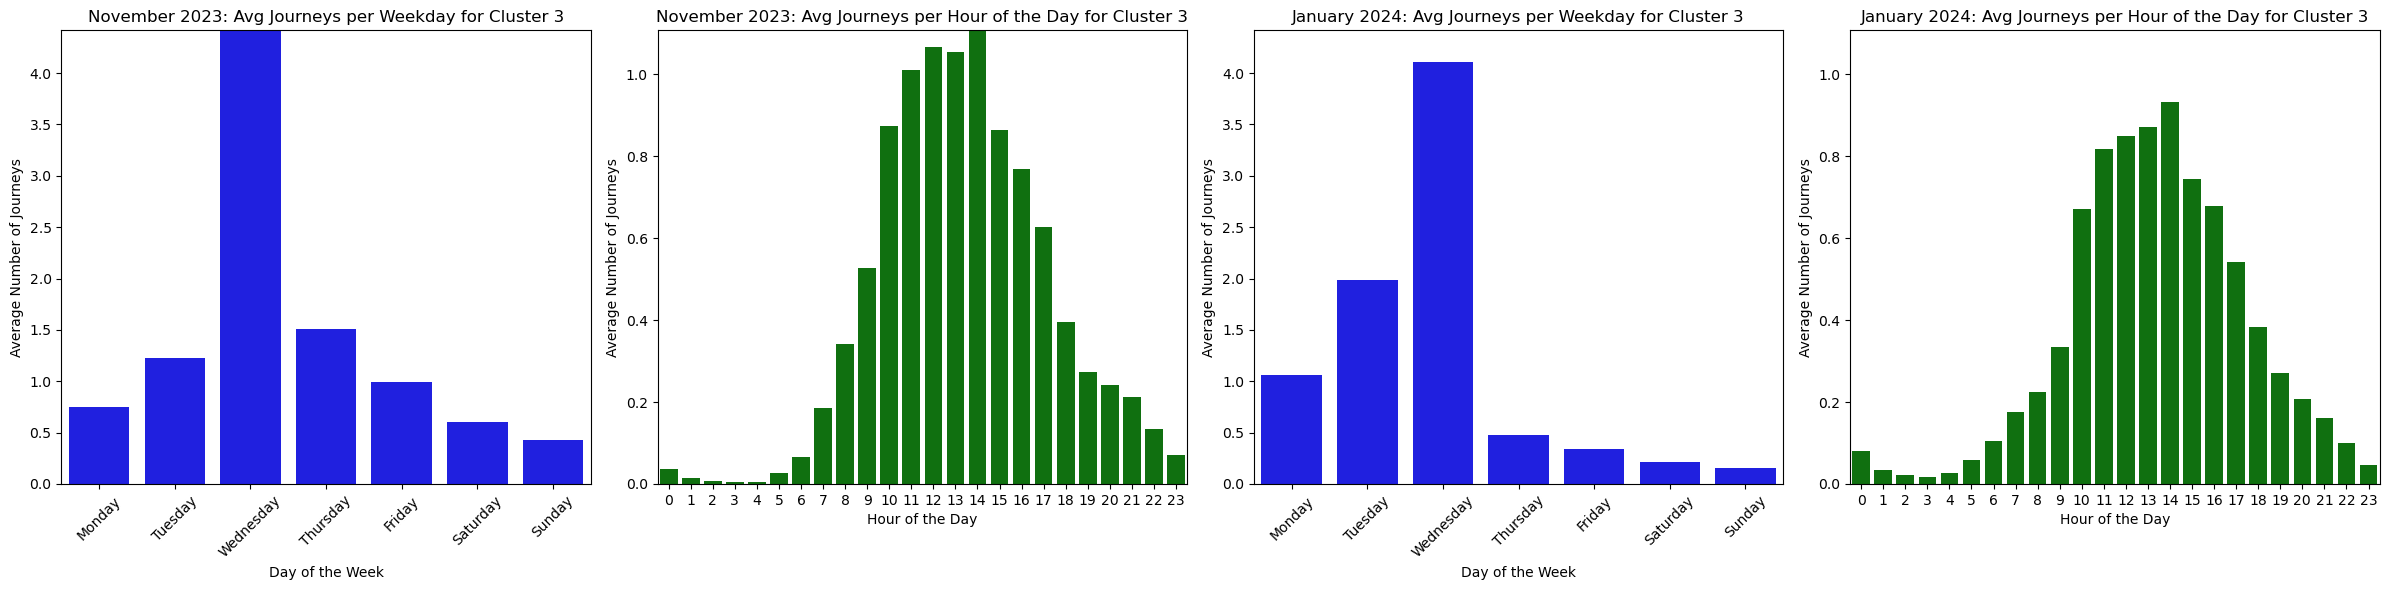

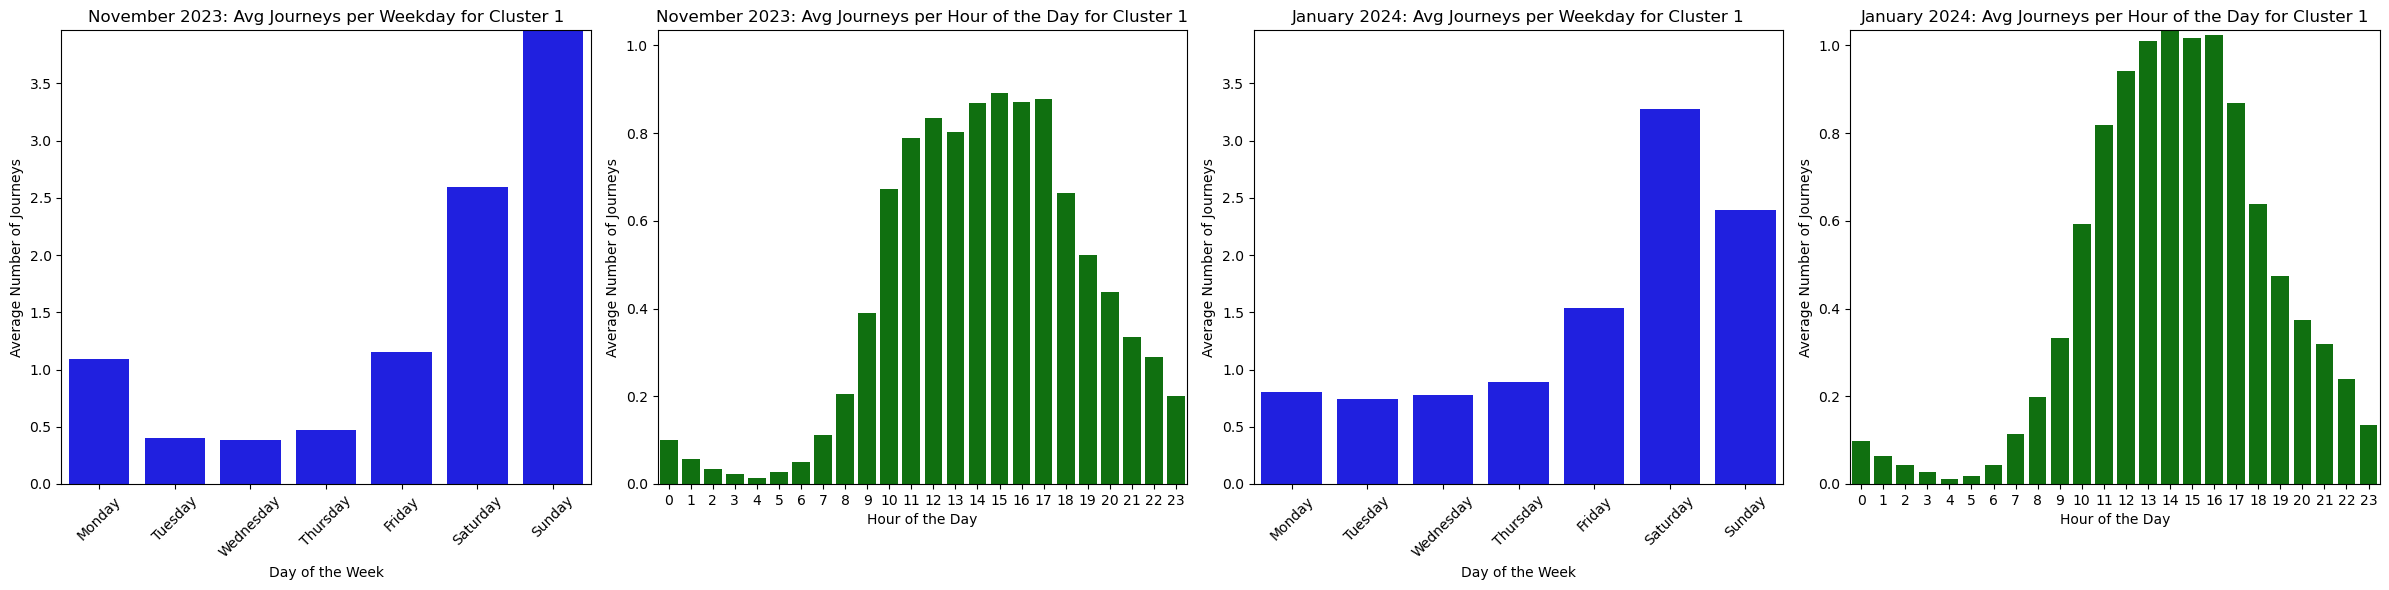

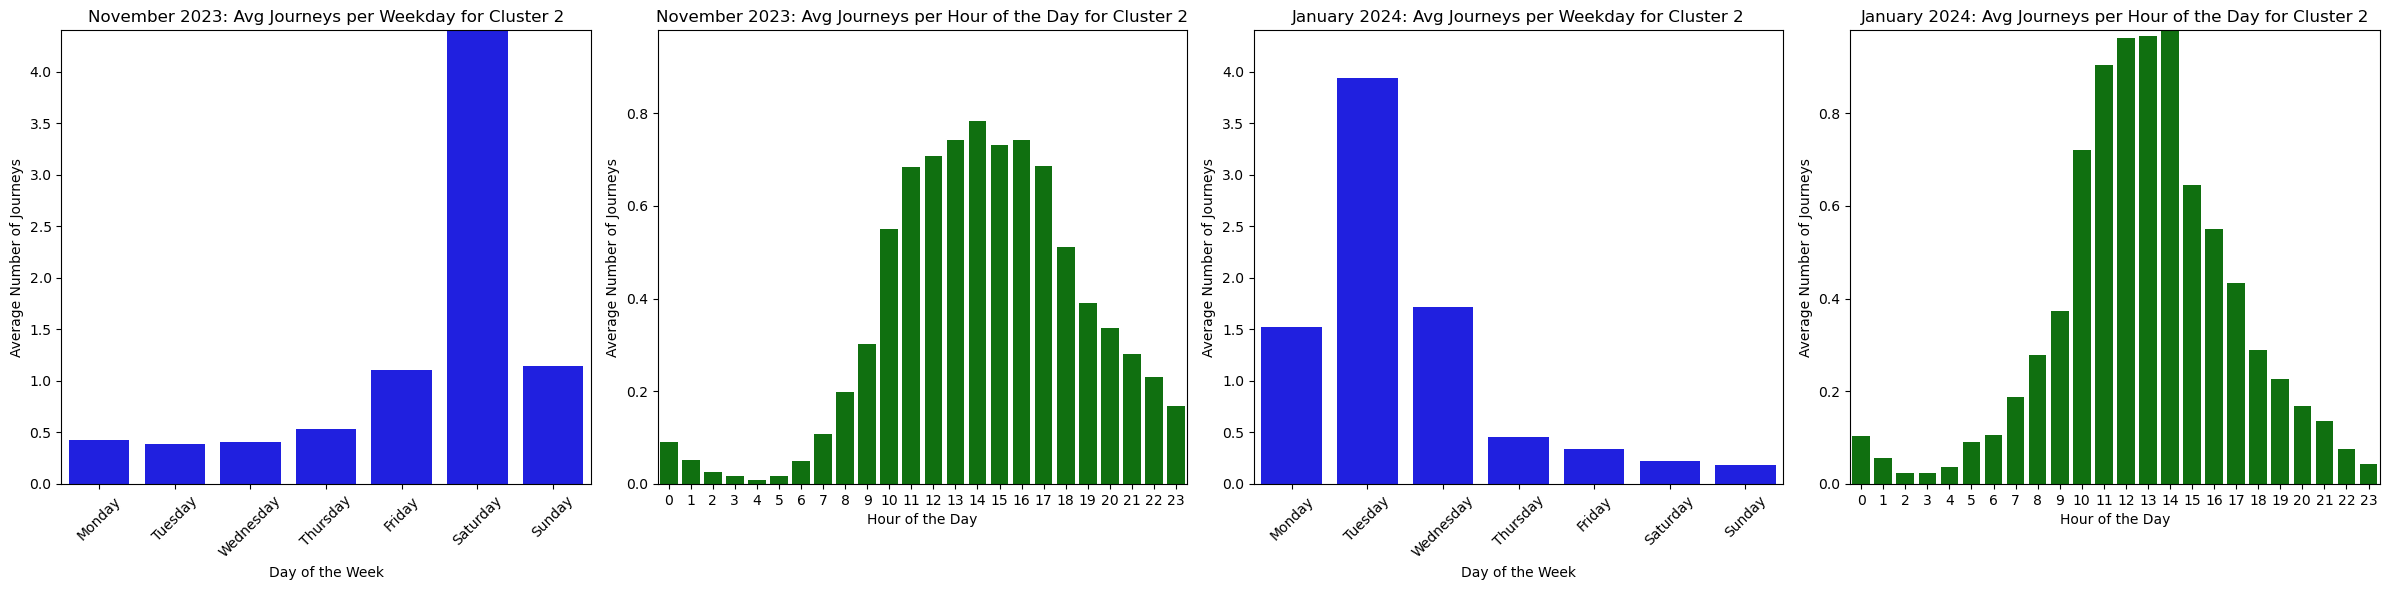

In [268]:
visualize_clusters(clustered_data_one, clustered_data_two)

In [223]:
def count_ticket_categories(clustered_data):
    # Group by CardKey and Class to ensure each user is only counted once
    grouped_data = clustered_data.groupby(['CardKey', 'Class']).first().reset_index()

    # Count the number of users for each TicketCategory within each class
    ticket_counts = grouped_data.groupby(['Class', 'TicketCategory']).size().unstack(fill_value=0)

    # Add a total count for each class
    ticket_counts['Total'] = ticket_counts.sum(axis=1)

    return ticket_counts

def print_ticket_category_counts(ticket_counts, period_name):
    print(f"Ticket Category Counts for {period_name}:\n")
    for cls in ticket_counts.index:
        print(f"Class {cls}: {ticket_counts.loc[cls, 'Total']} total members")
        for category in ticket_counts.columns:
            if category != 'Total':
                print(f"  {category}: {ticket_counts.loc[cls, category]} users")
        print("\n")

StatementMeta(dslsmall, 491, 224, Finished, Available)

### Count the number of users from each ticket category for each cluster 

In [269]:
# Count ticket categories for both periods
ticket_counts_one = count_ticket_categories(clustered_data_one)
ticket_counts_two = count_ticket_categories(clustered_data_two)

# Print the counts for both periods
print_ticket_category_counts(ticket_counts_one, TIME_PERIODS_NAME[P1])
print_ticket_category_counts(ticket_counts_two, TIME_PERIODS_NAME[P2])

StatementMeta(dslsmall, 491, 270, Finished, Available)

Ticket Category Counts for November 2023:

Class 1: 13064 total members
  Period: 0 users
  School: 0 users
  Single: 4977 users
  Tourist: 8087 users


Class 2: 9696 total members
  Period: 0 users
  School: 0 users
  Single: 5318 users
  Tourist: 4378 users


Class 3: 6981 total members
  Period: 0 users
  School: 0 users
  Single: 4435 users
  Tourist: 2546 users


Class 4: 129164 total members
  Period: 48163 users
  School: 52857 users
  Single: 17795 users
  Tourist: 10349 users


Class 5: 22103 total members
  Period: 0 users
  School: 0 users
  Single: 12854 users
  Tourist: 9249 users


Class 6: 28667 total members
  Period: 5278 users
  School: 6459 users
  Single: 10253 users
  Tourist: 6677 users


Ticket Category Counts for January 2024:

Class 1.0: 5211 total members
  Period: 0 users
  School: 0 users
  Single: 3280 users
  Tourist: 1931 users


Class 2.0: 4999 total members
  Period: 1999 users
  School: 0 users
  Single: 1523 users
  Tourist: 1477 users


Class 3.0: 54

In [271]:
def calculate_silhouette_score(X, labels):
    score = silhouette_score(X, labels)
    return score

def calculate_bic(X, n_components_range):
    bics = []
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components, random_state=42)
        gmm.fit(X)
        bics.append(gmm.bic(X))
    return bics

# Example usage with your data
def evaluate_clusters(X, labels, n_components_range):
    silhouette = calculate_silhouette_score(X, labels)
    print(f"Silhouette Score: {silhouette}")

    bics = calculate_bic(X, n_components_range)
    for n_components, bic in zip(n_components_range, bics):
        print(f"BIC for {n_components} components: {bic}")

    return silhouette, bics

StatementMeta(dslsmall, 491, 272, Finished, Available)

### Slow function when working with a lot of data points

In [272]:
# Example data
X1 = combined_X_one
labels1 = combined_Y_one['Class']
X2 = combined_X_two
labels2 = combined_Y_two['Class']

# Range of components for BIC calculation
n_components_range = range(1, 10)

# Evaluate clusters for both periods
print(f"Evaluating clusters for {TIME_PERIODS_NAME[P1]}:")
silhouette1, bics1 = evaluate_clusters(X1, labels1, n_components_range)

print(f"Evaluating clusters for {TIME_PERIODS_NAME[P2]}:")
silhouette2, bics2 = evaluate_clusters(X2, labels2, n_components_range)

StatementMeta(dslsmall, 491, 273, Finished, Available)

Evaluating clusters for November 2023:
Silhouette Score: 0.14376409440624477
BIC for 1 components: -29033680.365435302
BIC for 2 components: -35774173.540488444
BIC for 3 components: -38660618.18127918
BIC for 4 components: -41814462.11975493
BIC for 5 components: -43859520.58348602
BIC for 6 components: -44508484.70072678
BIC for 7 components: -45509021.958710566
BIC for 8 components: -46392289.59824023
BIC for 9 components: -47206438.42815315
Evaluating clusters for January 2024:


ValueError: Input y contains NaN.

# Data Statistics e.g. number of ticket for a month or the spread of ticket categories

In [19]:
def get_data1(time_period):
    """
    Fetches and prepares weekly profiles for each user over a specified time period.

    Parameters:
    - time_period: Tuple of start_date and end_date in the format "YYYY-MM-DD HH:MM:SS".

    Returns:
    - A Pandas DataFrame with the weekly profiles of journeys per user.
    """
    data_pdf = fetch_data1(time_period)

    # Calculate and print required data
    total_unique_cardkeys = data_pdf['CardKey'].nunique()
    total_journeys = data_pdf['ntrips'].sum()
    total_trip_count = len(data_pdf)

    print(f"Total unique CardKeys: {total_unique_cardkeys}")
    print(f"Total number of journeys: {total_journeys}")
    print(f"Total trip count: {total_trip_count}")

    # Calculate average unique cards and journeys per weekday and weekend
    data_pdf['DayType'] = data_pdf['DayOfWeek'].apply(lambda x: 'Weekday' if x in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'] else 'Weekend')

    avg_unique_cards = data_pdf.groupby('DayType')['CardKey'].nunique().mean()
    avg_journeys = data_pdf.groupby('DayType')['ntrips'].mean()

    print(f"Average number of unique cards per weekday/weekend: {avg_unique_cards}")
    print(f"Average number of journeys per weekday/weekend: {avg_journeys}")

    return data_pdf

def fetch_data1(time_period):
    start_date, end_date = time_period
    query = f"""
        SELECT 
            j.CardKey,
            j.n_trips AS ntrips,
            d.DayOfWeek
        FROM `analysis_dm`.`travelpatternjourney` AS j
        LEFT JOIN `analysis_dm`.`dimcalendardate` AS d 
            ON d.calendarDateKey = j.origin_CalendarDateKey
        WHERE 1=1
            AND d.FullDate BETWEEN '{start_date}' AND '{end_date}'
    """
    data_df = spark.sql(query).na.drop()
    data_pdf = data_df.toPandas()
    data_pdf['DayOfWeek'] = data_pdf['DayOfWeek'].map(DAY_MAPPING)

    return data_pdf

StatementMeta(dslsmall, 492, 20, Finished, Available)

In [24]:
TIME_PERIODS_NAME[5]

StatementMeta(dslsmall, 492, 25, Finished, Available)

'November 2023'

In [27]:
timePeriod = TIME_PERIODS[5]
data_pdf = get_data1(timePeriod)

StatementMeta(dslsmall, 492, 28, Finished, Available)

Total unique CardKeys: 2116524
Total number of journeys: 42372772
Total trip count: 32178803
Average number of unique cards per weekday/weekend: 1532131.5
Average number of journeys per weekday/weekend: DayType
Weekday    1.326841
Weekend    1.271190
Name: ntrips, dtype: float64


In [21]:
def get_data2(time_period):
    """
    Fetches and prepares weekly profiles for each user over a specified time period.

    Parameters:
    - time_period: Tuple of start_date and end_date in the format "YYYY-MM-DD HH:MM:SS".

    Returns:
    - A Pandas DataFrame with the weekly profiles of journeys per user.
    """
    data_pdf = fetch_data2(time_period)

    # Calculate and print data for each ticket category
    category_stats = data_pdf.groupby('TicketCategory').agg(
        unique_cardkeys=('CardKey', 'nunique'),
        total_journeys=('CardKey', 'size'),
        total_trip_count=('ntrips', 'sum')
    ).reset_index()

    print("\nTicket Category Statistics:")
    print(category_stats)

    return data_pdf

def fetch_data2(time_period):
    start_date, end_date = time_period
    query = f"""
        SELECT 
            j.CardKey,
            j.n_trips AS ntrips,
            d.DayOfWeek,
            p.ProductName
        FROM `analysis_dm`.`travelpatternjourney` AS j
        LEFT JOIN `analysis_dm`.`dimcalendardate` AS d 
            ON d.calendarDateKey = j.origin_CalendarDateKey
        LEFT JOIN `analysis_dm`.`dimvalidationproduct` AS p 
            ON p.ValidationProductKey = j.ValidationProductKey
        WHERE 1=1
            AND d.FullDate BETWEEN '{start_date}' AND '{end_date}'
    """
    data_df = spark.sql(query).na.drop()
    data_pdf = data_df.toPandas()
    data_pdf['DayOfWeek'] = data_pdf['DayOfWeek'].map(DAY_MAPPING)

    # Simplify tickets
    data_pdf['TicketCategory'] = data_pdf['ProductName'].map(TICKET_MAPPING).map(CATEGORY_MAPPING)
    data_pdf.dropna(subset=['TicketCategory'], inplace=True) # For those items not mapped
    data_pdf.drop(columns=["ProductName"], inplace=True)

    return data_pdf

StatementMeta(dslsmall, 492, 22, Finished, Available)

In [28]:
timePeriod = TIME_PERIODS[5]
data_pdf = get_data2(timePeriod)

StatementMeta(dslsmall, 492, 29, Finished, Available)


Ticket Category Statistics:
  TicketCategory  unique_cardkeys  total_journeys  total_trip_count
0         Period           394988         5764607           7913057
1         School           177712         4393024           5914886
2         Single           666853         3041281           3899739
3        Tourist            25756          180582            226662


In [30]:
def get_data3(time_period):
    """
    Fetches and prepares weekly profiles for each user over a specified time period.

    Parameters:
    - time_period: Tuple of start_date and end_date in the format "YYYY-MM-DD HH:MM:SS".

    Returns:
    - A Pandas DataFrame with the weekly profiles of journeys per user.
    """
    data_pdf = fetch_data3(time_period)

    # Calculate and print data for each ticket category
    category_stats = data_pdf.groupby('TicketCategory').agg(
        unique_cardkeys=('CardKey', 'nunique'),
        total_journeys=('CardKey', 'size'),
        total_trip_count=('ntrips', 'sum')
    ).reset_index()

    print("\nTicket Category Statistics:")
    print(category_stats)

    # Check how many CardKeys are in multiple ticket categories
    cardkey_counts = data_pdf.groupby('CardKey')['TicketCategory'].nunique()
    multiple_categories_count = cardkey_counts[cardkey_counts > 1].count()

    print(f"\nNumber of CardKeys in multiple ticket categories: {multiple_categories_count}")

    return data_pdf

def fetch_data3(time_period):
    start_date, end_date = time_period
    query = f"""
        SELECT 
            j.CardKey,
            j.n_trips AS ntrips,
            d.DayOfWeek,
            p.ProductName
        FROM `analysis_dm`.`travelpatternjourney` AS j
        LEFT JOIN `analysis_dm`.`dimcalendardate` AS d 
            ON d.calendarDateKey = j.origin_CalendarDateKey
        LEFT JOIN `analysis_dm`.`dimvalidationproduct` AS p 
            ON p.ValidationProductKey = j.ValidationProductKey
        WHERE 1=1
            AND d.FullDate BETWEEN '{start_date}' AND '{end_date}'
    """
    data_df = spark.sql(query).na.drop()
    data_pdf = data_df.toPandas()
    data_pdf['DayOfWeek'] = data_pdf['DayOfWeek'].map(DAY_MAPPING)

    # Simplify tickets
    data_pdf['TicketCategory'] = data_pdf['ProductName'].map(TICKET_MAPPING).map(CATEGORY_MAPPING)
    data_pdf.dropna(subset=['TicketCategory'], inplace=True) # For those items not mapped
    data_pdf.drop(columns=["ProductName"], inplace=True)

    return data_pdf


StatementMeta(dslsmall, 492, 31, Finished, Available)

In [34]:
timePeriod = TIME_PERIODS[5]
data_pdf = get_data3(timePeriod)

StatementMeta(dslsmall, 492, 35, Finished, Available)


Ticket Category Statistics:
  TicketCategory  unique_cardkeys  total_journeys  total_trip_count
0         Period           394988         5764607           7913057
1         School           177712         4393024           5914886
2         Single           666853         3041281           3899739
3        Tourist            25756          180582            226662

Number of CardKeys in multiple ticket categories: 65893
